In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import glob
import re
import xmltodict
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as tick
from matplotlib.backends.backend_pdf import PdfPages

from datetime import datetime
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [2]:
Drive = 'E'

In [3]:
decode(("iso-8859-15"

SyntaxError: unexpected EOF while parsing (<ipython-input-3-c79ff365eaab>, line 1)

## Functions

In [ ]:
def getfilename(path):
    # this function extracts the file name without file path or extension
    return path.split('\\').pop().split('/').pop().rsplit('.', 1)[0]

### Compilation

The script below uses a complete file path with wildcard ending to find all of the relevant files in a directory (folder) to generate a Pandas dataframe of all of the compiled data, with duplicates removed and datetimes sorted.

In [4]:
def compilation(inputfile):
    """
    This function reads multiple Solinst transducer files in a directory and generates a compiled Pandas dataframe.
    
    inputfile = complete file path to input files; use * for wildcard in file name
        example -> 'O:\\Snake Valley Water\\Transducer Data\\Raw_data_archive\\all\\LEV\\*baro*' picks any file containing 'baro'
    
    packages required:
        pandas as pd
        glob
        os
        xmltodict
    """
        
    # create empty dictionary to hold dataframes
    f={}

    # generate list of relevant files
    filelist = glob.glob(inputfile)

    # iterate through list of relevant files
    for infile in filelist:
        # get the extension of the input file
        filetype = os.path.splitext(infile)[1]
        # run computations using lev files
        if filetype=='.lev':
            # open text file
            with open(infile) as fd:
                # find beginning of data
                indices = fd.readlines().index('[Data]\n')

            # convert data to pandas dataframe starting at the indexed data line
            f[getfilename(infile)] = pd.read_table(infile, parse_dates=True, sep='     ', index_col=0,
                                           skiprows=indices+2, names=['DateTime','Level','Temperature'], skipfooter=1,engine='python')
            # add extension-free file name to dataframe
            f[getfilename(infile)]['name'] = getfilename(infile)
            
        # run computations using xle files
        elif filetype=='.xle':
            # open text file
            with open(infile) as fd:
                # parse xml
                obj = xmltodict.parse(fd.read(),encoding="ISO-8859-1")
            # navigate through xml to the data
            wellrawdata = obj['Body_xle']['Data']['Log']
            # convert xml data to pandas dataframe
            f[getfilename(infile)] = pd.DataFrame(wellrawdata)
            # get header names and apply to the pandas dataframe          
            f[getfilename(infile)][str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = f[getfilename(infile)]['ch1']
            f[getfilename(infile)][str(obj['Body_xle']['Ch2_data_header']['Identification']).title()] = f[getfilename(infile)]['ch2']
  
            # add extension-free file name to dataframe
            f[getfilename(infile)]['name'] = getfilename(infile)
            # combine Date and Time fields into one field
            f[getfilename(infile)]['DateTime'] = pd.to_datetime(f[getfilename(infile)].apply(lambda x: x['Date'] + ' ' + x['Time'], 1))
            f[getfilename(infile)] = f[getfilename(infile)].reset_index()
            f[getfilename(infile)] = f[getfilename(infile)].set_index('DateTime')
            f[getfilename(infile)] = f[getfilename(infile)].drop(['Date','Time','@id','ch1','ch2','index','ms'],axis=1)
        # run computations using csv files

        else:
            pass
    # concatonate all of the dataframes in dictionary f to one dataframe: g
    g = pd.concat(f)
    # remove multiindex and replace with index=Datetime
    g = g.reset_index()
    g = g.set_index(['DateTime'])
    # drop old indexes
    g = g.drop(['level_0'],axis=1)
    # remove duplicates based on index then sort by index
    g['ind']=g.index
    g.drop_duplicates(subset='ind',inplace=True)
    g.drop('ind',axis=1,inplace=True)
    g = g.sort()
    # ensure that the Level and Temperature data are in a float format
    g['Level'] = g['Level'].convert_objects(convert_numeric=True)
    g['Temperature'] = g['Temperature'].convert_objects(convert_numeric=True)
    outfile = g
    return outfile

### Appendomatic

The appendomatic function below appends new data (infile) onto existing data by parsing the new data and making it the same format as the existing data, then merging the datasets, then overwriting the existing data.

In [5]:
def appendomatic(infile,existingfile):
    '''
    appends data from one table to an existing compilation
    this tool will delete and replace the existing file

    infile = input file
    existingfile = file you wish to append to
    '''

    # get the extension of the input file
    filetype = os.path.splitext(infile)[1]
    
    # run computations using lev files
    if filetype=='.lev':
        # open text file
        with open(infile) as fd:
            # find beginning of data
            indices = fd.readlines().index('[Data]\n')

        # convert data to pandas dataframe starting at the indexed data line
        f = pd.read_table(infile, parse_dates=True, sep='     ', index_col=0,
                                       skiprows=indices+2, names=['DateTime','Level','Temperature'], skipfooter=1,engine='python')
        # add extension-free file name to dataframe
        f['name'] = getfilename(infile)

    # run computations using xle files
    elif filetype=='.xle':
        # open text file
        with open(infile) as fd:
            # parse xml
            obj = xmltodict.parse(fd.read(),encoding="ISO-8859-1")
        # navigate through xml to the data
        wellrawdata = obj['Body_xle']['Data']['Log']
        # convert xml data to pandas dataframe
        f = pd.DataFrame(wellrawdata)
        # get header names and apply to the pandas dataframe
        f[str(obj['Body_xle']['Ch2_data_header']['Identification']).title()] = f['ch2']
        unit = str(obj['Body_xle']['Ch1_data_header']['Unit']).lower()
        if unit == "feet":
            f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = f['ch1']
        elif unit == "kpa":
            f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = f['ch1']*0.33456
        elif unit == "mbar":
            f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = f['ch1']*0.0334552565551
        elif unit == "psi":
            f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = f['ch1']*2.306726
        else:
            f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = f['ch1']
            print "Unknown Units"
        # add extension-free file name to dataframe
        f['name'] = getfilename(infile)
        # combine Date and Time fields into one field
        f['DateTime'] = pd.to_datetime(f.apply(lambda x: x['Date'] + ' ' + x['Time'], 1))
        f = f.reset_index()
        f = f.set_index('DateTime')
        f = f.drop(['Date','Time','@id','ch1','ch2','index','ms'],axis=1)
    
    # run computations using csv files
    elif filetype=='.csv':
        with open(infile) as fd:
        # find beginning of data
            try:
                indices = fd.readlines().index('Date,Time,ms,Level,Temperature\n')
            except ValueError:
                indices = fd.readlines().index(',Date,Time,100 ms,Level,Temperature\n')
        f = pd.read_csv(infile, skiprows=indices, skipfooter=1, engine='python')
        # add extension-free file name to dataframe
        f['name'] = getfilename(infile)
        # combine Date and Time fields into one field
        f['DateTime'] = pd.to_datetime(f.apply(lambda x: x['Date'] + ' ' + x['Time'], 1))
        f = f.reset_index()
        f = f.set_index('DateTime')
        f = f.drop(['Date','Time','ms','index'],axis=1)
            # skip other file types
    else:
        pass

    # ensure that the Level and Temperature data are in a float format
    f['Level'] = f['Level'].convert_objects(convert_numeric=True)
    f['Temperature'] = f['Temperature'].convert_objects(convert_numeric=True)
    h = pd.read_csv(existingfile,index_col=0,header=0,parse_dates=True)
    g = pd.concat([h,f])
    # remove duplicates based on index then sort by index
    g['ind']=g.index
    g.drop_duplicates(subset='ind',inplace=True)
    g.drop('ind',axis=1,inplace=True)
    g = g.sort()    
    os.remove(existingfile)
    g.to_csv(existingfile)

### Make Files Table 

In [6]:
def make_files_table(folder, wellinfo):
    '''
    This tool will make a descriptive table (Pandas DataFrame) containing filename, date, and site id.
    For it to work properly, files must be named in the following fashion:
    siteid YYYY-MM-DD
    example: pw03a 2015-03-15.csv

    This tool assumes that if there are two files with the same name but different extensions, 
    then the datalogger for those data is a Solinst datalogger.

    folder = directory containing the newly downloaded transducer data
    '''

    filenames = next(os.walk(folder))[2]
    site_id, exten, dates, fullfilename = [],[],[],[]
    # parse filename into relevant pieces
    for i in filenames:
        site_id.append(i[:-15].lower())
        exten.append(i[-4:])
        dates.append(i[-14:-4])
        fullfilename.append(i)
    files = {'siteid':site_id,'extensions':exten,'date':dates,'full_file_name':fullfilename}
    files = pd.DataFrame(files)
    files['filedups'] = files.duplicated(subset='siteid')
    files['LoggerTypeID'] = files['filedups'].astype('int')+1
    files['LoggerTypeName']=files['LoggerTypeID'].apply(lambda x: 'Solinst' if x==2 else 'Global Water')
    files.drop_duplicates(subset='siteid',take_last=True,inplace=True)

    #wellinfo = pd.read_csv(wellinfofile,header=0,index_col=0)
    wellinfo = wellinfo[wellinfo['Well']!=np.nan]
    wellinfo["G_Elev_m"] = np.divide(wellinfo["GroundElevation"],3.2808)
    wellinfo['Well'] = wellinfo['Well'].apply(lambda x: str(x).lower().strip())
    files = pd.merge(files,wellinfo,left_on='siteid',right_on='Well')
    
    return files

### Barodistance

In [7]:
def barodistance(wellinfo):
    '''
    Determines Closest Barometer to Each Well using wellinfo DataFrame
    '''
    barometers = {'barom':['pw03','pw10','pw19'], 'X':[240327.49,271127.67,305088.9], 
                  'Y':[4314993.95,4356071.98,4389630.71], 'Z':[1623.079737,1605.187759,1412.673738]}
    barolocal = pd.DataFrame(barometers)
    barolocal = barolocal.reset_index()
    barolocal.set_index('barom',inplace=True)

    wellinfo['pw03'] = np.sqrt((barolocal.loc['pw03','X']-wellinfo['UTMEasting'])**2 + 
                                   (barolocal.loc['pw03','Y']-wellinfo['UTMNorthing'])**2 + 
                                   (barolocal.loc['pw03','Z']-wellinfo['G_Elev_m'])**2)
    wellinfo['pw10'] = np.sqrt((barolocal.loc['pw10','X']-wellinfo['UTMEasting'])**2 + 
                                   (barolocal.loc['pw10','Y']-wellinfo['UTMNorthing'])**2 + 
                                   (barolocal.loc['pw10','Z']-wellinfo['G_Elev_m'])**2)
    wellinfo['pw19'] = np.sqrt((barolocal.loc['pw19','X']-wellinfo['UTMEasting'])**2 + 
                                   (barolocal.loc['pw19','Y']-wellinfo['UTMNorthing'])**2 + 
                                   (barolocal.loc['pw19','Z']-wellinfo['G_Elev_m'])**2)
    wellinfo['closest_baro'] = wellinfo[['pw03','pw10','pw19']].T.idxmin()
    return wellinfo

### New Well Import

#### Import xle File

In [15]:
def new_xle_imp(infile):
    '''
    This function uses an exact file path to upload a Solinst xle file. 
    
    infile = complete file path to input file
    
    RETURNS
    A pandas dataframe containing the transducer data
    '''
    # open text file
    with open(infile) as fd:
        # parse xml
        obj = xmltodict.parse(fd.read(),encoding="ISO-8859-1")
    # navigate through xml to the data
    wellrawdata = obj['Body_xle']['Data']['Log']
    # convert xml data to pandas dataframe
    f = pd.DataFrame(wellrawdata)
    # get header names and apply to the pandas dataframe
    f[str(obj['Body_xle']['Ch2_data_header']['Identification']).title()] = f['ch2']
    
    tempunit = str(obj['Body_xle']['Ch2_data_header']['Unit'])
    if tempunit == 'Deg C' or tempunit == u'\N{DEGREE SIGN}'+'C':
        f[str(obj['Body_xle']['Ch2_data_header']['Identification']).title()] = f['ch2']
    elif tempunit == 'Deg F' or tempunit == u'\N{DEGREE SIGN}'+'F': 
        f[str(obj['Body_xle']['Ch2_data_header']['Identification']).title()] = f['ch2']*0.33456
    else:
        f[str(obj['Body_xle']['Ch2_data_header']['Identification']).title()] = f['ch2']
        print "Unknown Units"
    levelunit = str(obj['Body_xle']['Ch1_data_header']['Unit']).lower()
    if levelunit == "feet":
        f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = f['ch1']
    elif levelunit == "kpa":
        f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = f['ch1']*0.33456
    elif levelunit == "mbar":
        f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = f['ch1']*0.0334552565551
    elif levelunit == "psi":
        f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = f['ch1']*2.306726
    else:
        f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = f['ch1']
        print "Unknown Units"
    # add extension-free file name to dataframe
    f['name'] = getfilename(infile)
    # combine Date and Time fields into one field
    f['DateTime'] = pd.to_datetime(f.apply(lambda x: x['Date'] + ' ' + x['Time'], 1))
    f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()].convert_objects(convert_numeric=True)
    f[str(obj['Body_xle']['Ch2_data_header']['Identification']).title()] = f[str(obj['Body_xle']['Ch2_data_header']['Identification']).title()].convert_objects(convert_numeric=True)
    f = f.reset_index()
    f = f.set_index('DateTime')
    f = f.drop(['Date','Time','@id','ch1','ch2','index','ms'],axis=1)
    return f

#### Import Well File

In [8]:
def getwellid(infile,wellinfo):
    m = re.search("\d", getfilename(infile))
    s = re.search("\s", getfilename(infile))
    if m.start() > 3:
        wellname = getfilename(infile)[0:m.start()].strip().lower()
    else:
        wellname = getfilename(infile)[0:s.start()].strip().lower()
    wellid = wellinfo[wellinfo['Well']==wellname]['WellID'].values[0]
    return wellname, wellid

Use `g[wellinfo[wellinfo['Well']==wellname]['closest_baro']]` instead if you want to match the closest barometer to the data

In [9]:
def imp_new_well(infile, wellinfo, manual, baro):
    '''
    INPUT
    infile = full file path of well to import
    wellinfo = pandas dataframe containing infomation of snake valley wells
    manual = pandas dataframe containing manual water level measurements
    
    OUTPUT
    a pandas dataframe and a csv file
    
    This function imports xle (solinst) and csv (Global Water) transducer files, removes barometric pressure effects and corrects for drift.
    ''' 
    wellname, wellid = getwellid(infile,wellinfo) #see custom getwellid function
    if wellinfo[wellinfo['Well']==wellname]['LoggerTypeName'].values[0] == 'Solinst': # Reads Solinst Raw File
        f = new_xle_imp(infile)
        bse = f.index.to_datetime().minute[0]
        bp = wellinfo[wellinfo['Well']==wellname]['BE barologger']
        b = hourly_resample(baro[bp], bse)
        g = pd.merge(f,b,left_index=True,right_index=True,how='inner')
        
        g['MeasuredLevel'] = g['Level']         
        
        # Remove first and/or last measurements if the transducer was out of the water
        ## Examine First Value
        firstupper = np.mean(g['MeasuredLevel'].diff()[2:31]) + np.std(g['MeasuredLevel'].diff()[2:31])*2.2 # 2.2 std dev.
        firstlower = np.mean(g['MeasuredLevel'].diff()[2:31]) - np.std(g['MeasuredLevel'].diff()[2:31])*2.2 # 2.2 std dev.
        firstlev = g['MeasuredLevel'].diff()[1:2].values[0] # difference of first two values
        ## Examine Last Value
        lastupper = np.mean(g['MeasuredLevel'].diff()[-31:-2]) + np.std(g['MeasuredLevel'].diff()[-31:-2])*2.2 # 2.2 std dev.
        lastlower = np.mean(g['MeasuredLevel'].diff()[-31:-2]) - np.std(g['MeasuredLevel'].diff()[-31:-2])*2.2 # 2.2 std dev.
        lastlev = g['MeasuredLevel'].diff()[-2:-1].values[0] # difference of last two values
        ## drop first value if 2.2 std dev beyond first 30 values
        if np.abs(firstlev) > 0.1:
            if firstlev > firstupper or firstlev < firstlower:
                g.drop(g.index[0],inplace=True)
        ## drop last value if 2.2 std dev beyond last 30 values
        if np.abs(lastlev) > 0.1:
            if lastlev > lastupper or lastlev < lastlower:
                g.drop(g.index[-1],inplace=True)
        
        glist = f.columns.tolist()
        if 'Temperature' in glist:
            g['Temp'] = g['Temperature']
            g.drop(['Temperature'],inplace=True,axis=1)
        elif 'Temp' in glist:
            pass
        # Get Baro Efficiency
        be = wellinfo[wellinfo['WellID']==wellid]['BaroEfficiency']
        be = be.iloc[0]
    
        # Barometric Efficiency Correction
        g['BaroEfficiencyCorrected'] = g['MeasuredLevel'] - g[wellinfo[wellinfo['Well']==wellname]['BE barologger']] + be*g[wellinfo[wellinfo['Well']==wellname]['BE barologger']]
    else: # Reads Global Water Raw File
        f = pd.read_csv(infile,skiprows=1,parse_dates=[[0,1]])
        f = f.reset_index()
        f['DateTime'] = f['Date_ Time']
        f['Level'] = f[' Feet']
        flist = f.columns.tolist()
        if ' Temp C' in flist:
            f['Temperature'] = f[' Temp C']
            f['Temp'] = f['Temperature']
            f.drop([' Temp C','Temperature'],inplace=True,axis=1)
        else:
            f['Temp'] = np.nan
        f = f.set_index('DateTime')
        f['date'] = f.index.to_julian_date().values
        f['datediff'] = f['date'].diff()
        f = f[f['datediff']>0]
        f = f[f['datediff']<1]
        f = f.resample("60Min")
        f = f.interpolate(method='time')
        f.drop(['index',u' Volts',' Feet',u'date',u'datediff'],inplace=True,axis=1)        
        bse = f.index.to_datetime().minute[0]
        bp = wellinfo[wellinfo['Well']==wellname]['BE barologger']
        b = hourly_resample(baro[bp], bse)
        g = pd.merge(f,b,left_index=True,right_index=True,how='inner')
        g['MeasuredLevel'] = g['Level']
        
        # Remove first and/or last measurements if the transducer was out of the water
        ## Examine First Value
        firstupper = np.mean(g['MeasuredLevel'].diff()[2:31]) + np.std(g['MeasuredLevel'].diff()[2:31])*2.2 # 2.2 std dev.
        firstlower = np.mean(g['MeasuredLevel'].diff()[2:31]) - np.std(g['MeasuredLevel'].diff()[2:31])*2.2 # 2.2 std dev.
        firstlev = g['MeasuredLevel'].diff()[0:1].values[0] # difference of first two values
        ## Examine Last Value
        lastupper = np.mean(g['MeasuredLevel'].diff()[-31:-2]) + np.std(g['MeasuredLevel'].diff()[-31:-2])*2.2 # 2.2 std dev.
        lastlower = np.mean(g['MeasuredLevel'].diff()[-31:-2]) - np.std(g['MeasuredLevel'].diff()[-31:-2])*2.2 # 2.2 std dev.
        lastlev = g['MeasuredLevel'].diff()[-2:-1].values[0] # difference of last two values
        ## drop first value if 2.2 std dev beyond first 30 values
        if firstlev > 0.1:
            if firstlev > firstupper or firstlev < firstlower:
                g.drop(g.index[0],inplace=True)
        ## drop last value if 2.2 std dev beyond last 30 values
        if lastlev > 0.1:
            if lastlev > lastupper or lastlev < lastlower:
                g.drop(g.index[-1],inplace=True)
        
        # Get Baro Efficiency
        be = wellinfo[wellinfo['WellID']==wellid]['BaroEfficiency']
        be = be.iloc[0]
    
        # Barometric Efficiency Correction
        g['BaroEfficiencyCorrected'] = g['MeasuredLevel'] + be*g[wellinfo[wellinfo['Well']==wellname]['BE barologger']]
                
    g['DeltaLevel'] = g['BaroEfficiencyCorrected'] - g['BaroEfficiencyCorrected'][0]
    
    # Match manual water level to closest date
    g['MeasuredDTW'] = fcl(manual[manual['WellID']== wellid],min(g.index.to_datetime()))[1]-g['DeltaLevel']

    # Drift Correction
    #lastdtw = g['MeasuredDTW'][-1]
    last = fcl(manual[manual['WellID']== wellid],max(g.index.to_datetime()))[1]
    first = fcl(manual[manual['WellID']== wellid],min(g.index.to_datetime()))[1]
    lastg = float(g[g.index.to_datetime()==max(g.index.to_datetime())]['MeasuredDTW'].values)
    driftlen = len(g.index)
    g['last_diff_int'] = np.round((lastg-last),4)/np.round(driftlen-1.0,4)
    g['DriftCorrection'] = np.round(g['last_diff_int'].cumsum()-g['last_diff_int'],4)
    
    # Assign well id to column
    g['WellID'] = wellid
    
    # Get Depth to water below casing
    g['DTWBelowCasing'] = g['MeasuredDTW'] - g['DriftCorrection']

    # subtract casing height from depth to water below casing
    g['DTWBelowGroundSurface'] = g['DTWBelowCasing'] - wellinfo[wellinfo['WellID']==wellid]['Offset'].values[0]
    
    # subtract depth to water below ground surface from well surface elevation
    g['WaterElevation'] = wellinfo[wellinfo['WellID']==wellid]['GroundElevation'].values[0] - g['DTWBelowGroundSurface']
    
    # assign tape value
    g['Tape'] = 0
    g['MeasuredBy'] = ''
    
    # generate new file
    pathlist = os.path.splitext(infile)[0].split('\\')
    outpath = pathlist[0] + '\\' + pathlist[1] + '\\' + pathlist[2] + '\\' + pathlist[3] + '\\' + pathlist[4] + '\\' + str(wellname) + '.csv'  
    g['DateTime'] = g.index.to_datetime()
    g.to_csv(outpath, index=False, columns= ["WellID","DateTime","MeasuredLevel","Temp","BaroEfficiencyCorrected","DeltaLevel",
                                             "MeasuredDTW","DriftCorrection","DTWBelowCasing","DTWBelowGroundSurface",
                                             "WaterElevation","Tape","MeasuredBy"])
    return g

### Resample

In [10]:
def hourly_resample(df,bse=0):
    df = df.resample('1Min')
    df = df.interpolate(method='time')
    df = df.resample('60Min', how='first',closed='left',label='left', base=bse)
    return df

### Find Closest Date

In [11]:
def fcl(df, dtObj):
    '''
    finds closest date index in a dataframe to a date object
    
    df = dataframe
    dtObj = date object
    
    taken from: http://stackoverflow.com/questions/15115547/find-closest-row-of-dataframe-to-given-time-in-pandas
    '''
    return df.iloc[np.argmin(np.abs(df.index.to_pydatetime() - dtObj))]

## Import Relevant Data

### Well Information

In [22]:
infile=r'E:\Snake Valley Water\Transducer Data\Raw_data_archive\2015\2015 q1\ag13a 2015-03-03.xle'
with open(infile) as fd:
    # parse xml
    obj = xmltodict.parse(fd.read(),encoding="ISO-8859-1")
# navigate through xml to the data
wellrawdata = obj['Body_xle']['Data']['Log']
# convert xml data to pandas dataframe
f = pd.DataFrame(wellrawdata)
# get header names and apply to the pandas dataframe
f[str(obj['Body_xle']['Ch2_data_header']['Identification']).title()] = f['ch2']

tempunit = str(obj['Body_xle']['Ch2_data_header']['Unit'].encode("ISO-8859-1"))
tempunit

'\xb0C'

In [57]:
folder = Drive + ':\\Snake Valley Water\\Transducer Data\\Raw_data_archive\\2015\\2015 q1'
wellinfofile = Drive + ':\\Snake Valley Water\\Transducer Data\\Raw_data_archive\\well table 2015-03-23.csv'

In [58]:
wellinfo = pd.read_csv(Drive + ':\\Snake Valley Water\\Transducer Data\\Raw_data_archive\\well table 2015-03-23.csv',header=0,index_col=0)
wellinfo["G_Elev_m"] = wellinfo["GroundElevation"]/3.2808
wellinfo["Well"] = wellinfo['Well'].apply(lambda x: str(x).lower().strip())
wellinfo['WellID'] = wellinfo.index.values

### Manual Water Levels

In [59]:
manualwls = Drive + ":\\Snake Valley Water\\Transducer Data\\Raw_data_archive\\All tape measurements.csv"
manual = pd.read_csv(manualwls, skiprows=0, parse_dates=0, index_col="DateTime", engine="python")

### Barometric Pressure Data

#### Compilation of Barometric Pressure Data

In [18]:
pw03baro_append = Drive + ":\\Snake Valley Water\\Transducer Data\\Raw_data_archive\\2015\\2015 q1\\pw03 baro 2015-03-04.xle"
pw10baro_append = Drive + ":\\Snake Valley Water\\Transducer Data\\Raw_data_archive\\2015\\2015 q1\\pw10 baro 2015-03-04.xle"
pw19baro_append = Drive + ":\\Snake Valley Water\\Transducer Data\\Raw_data_archive\\2015\\2015 q1\\pw19 baro 2015-03-05.xle"

In [19]:
pw03baro = Drive + ":\\Snake Valley Water\\Transducer Data\\Raw_data_archive\\pw03baro.csv"
pw10baro = Drive + ":\\Snake Valley Water\\Transducer Data\\Raw_data_archive\\pw10baro.csv"
pw19baro = Drive + ":\\Snake Valley Water\\Transducer Data\\Raw_data_archive\\pw19baro.csv"

In [20]:
appendomatic(pw03baro_append,pw03baro)
appendomatic(pw10baro_append,pw10baro)
appendomatic(pw19baro_append,pw19baro)

In [60]:
# duplicated to update changes made by appendomatic
pw03baro = pd.read_csv(Drive + ":\\Snake Valley Water\\Transducer Data\\Raw_data_archive\\pw03baro.csv",index_col='DateTime',parse_dates=True)
pw10baro = pd.read_csv(Drive + ":\\Snake Valley Water\\Transducer Data\\Raw_data_archive\\pw10baro.csv",index_col='DateTime',parse_dates=True)
pw19baro = pd.read_csv(Drive + ":\\Snake Valley Water\\Transducer Data\\Raw_data_archive\\pw19baro.csv",index_col='DateTime',parse_dates=True)

In [61]:
pw03baro['pw03'] = pw03baro['Level']
pw03baro = hourly_resample(pw03baro['pw03'].to_frame())
pw10baro['pw10'] = pw10baro['Level']
pw10baro = hourly_resample(pw10baro['pw10'].to_frame())
pw19baro['pw19'] = pw19baro['Level']
pw19baro = hourly_resample(pw19baro['pw19'].to_frame())

In [62]:
baro = pd.merge(pw03baro,pw10baro,how="outer",left_index=True,right_index=True)
baro = pd.merge(baro,pw19baro,how="outer",left_index=True,right_index=True)
baro.dropna(axis=0,inplace=True)
baro['integr'] = 0 #for vented transducers
baro[baro.index.to_datetime()==pd.datetime(2015,3,4,10)]

pw03    pw10    pw19  integr
DateTime                                           
2015-03-04 10:00:00  2.8196  3.2433  3.3271       0

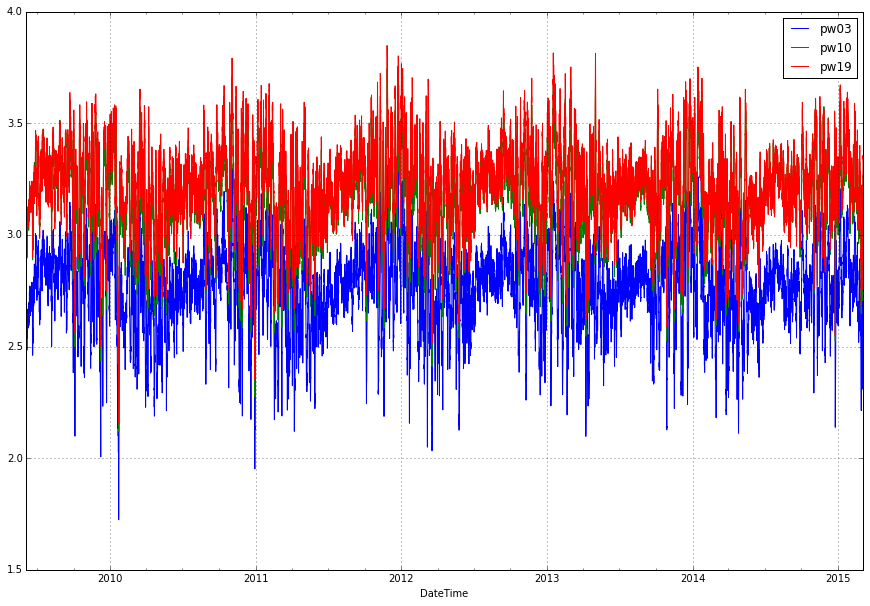

In [63]:
baro[['pw03','pw10','pw19']].plot()

In [64]:
folder = Drive + ":\\Snake Valley Water\\Transducer Data\\Raw_data_archive\\2015\\2015 q1\\"
wellinfo = barodistance(wellinfo)
wellinfo = make_files_table(folder, wellinfo)
wellinfo.tail(n=3)

date extensions                        full_file_name  \
65  2015-03-03       .xle                   sg27 2015-03-03.xle   
66  2015-03-03       .xle  snake valley north mx 2015-03-03.xle   
67  2015-03-02       .xle  snake valley south mx 2015-03-02.xle   

                   siteid filedups  LoggerTypeID_x LoggerTypeName  SiteID  \
65                   sg27     True               2        Solinst      27   
66  snake valley north mx     True               2        Solinst      29   
67  snake valley south mx     True               2        Solinst      30   

                     Well       WRNum     ...       \
65                   sg27  0818024M00     ...        
66  snake valley north mx         NaN     ...        
67  snake valley south mx         NaN     ...        

                                            ImagePath  \
65              Snake Valley images/Site 27 photo.jpg   
66  Snake Valley images/Snake Valley North MX phot...   
67  Snake Valley images/Snake Valley South MX phot...   

                                         LinkUSGSNWIS  VegType  BE barologger  \
65                                                NaN      NaN           pw03   
66  http://nwis.waterdata.usgs.gov/nwis/gwlevels/?...      NaN           pw03   
67  http://nwis.waterdata.usgs.gov/nwis/gwlevels/?...      NaN           pw03   

       G_Elev_m  WellID           pw03           pw10           pw19  \
65  1470.220678      68   57936.578772   29354.155782   60694.376110   
66  1553.310168      70  514145.011390  483328.241594  452138.041577   
67  1701.383809      71  514332.596554  486826.780302  458729.702821   

   closest_baro  
65         pw10  
66         pw19  
67         pw19  

[3 rows x 56 columns]

In [ ]:
wellinfo[wellinfo['Well']=='Needle Point BLM']

In [46]:
infile = Drive + ":\\Snake Valley Water\\Transducer Data\\Raw_data_archive\\2015\\2015 q1\\"
pathlist = os.path.splitext(infile)[0].split('\\')
baro.to_csv(pathlist[0] + '\\' + pathlist[1] + '\\' + pathlist[2] + '\\' + pathlist[3] + '\\' + pathlist[4] + '\\' + 'baro' + '.csv')

## Water Level Tranducer Data

### Export and Plot Data

#### Export Manual Data

In [70]:

manualrecent = manual[manual.index.to_datetime() > pd.datetime(2015,3,1)]
manualrecent.dropna(inplace=True)
manualrecent.reset_index(inplace=True)
manualrecent.set_index('WellID',inplace=True)

manualrecent["MeasuredLevel"] = np.nan
manualrecent["Temp"] = np.nan
manualrecent["BaroEfficiencyCorrected"] = np.nan 
manualrecent["DeltaLevel"] = np.nan
manualrecent["DriftCorrection"] = np.nan
manualrecent["MeasuredBy"] = np.nan
manualrecent["Tape"] = 1
manualrecent["DTWBelowGroundSurface"] = np.nan
manualrecent["WaterElevation"] = np.nan
#manualrecent["DTWBelowGroundSurface"] = np.nan
manlist=[int(i) for i in manualrecent.index.tolist()]

print manlist
for i in manlist:
    try:
        manualrecent.loc[i,"DTWBelowCasing"] = manualrecent.loc[i,"MeasuredDTW"]
        manualrecent.loc[i,"DTWBelowGroundSurface"] = manualrecent.loc[i,"MeasuredDTW"] - wellinfo.loc[i,"Offset"]
        manualrecent.loc[i,"WaterElevation"] = wellinfo.loc[i,'GroundElevation'] - manualrecent.loc[i,"DTWBelowGroundSurface"]
    except(KeyError):
        pass

outpath = pathlist[0] + '\\' + pathlist[1] + '\\' + pathlist[2] + '\\' + pathlist[3] + '\\' + pathlist[4] + '\\' + 'Manual' + '.csv'  
manualrecent.to_csv(outpath, index=True, columns= ["DateTime","MeasuredLevel","Temp","BaroEfficiencyCorrected","DeltaLevel",
                                             "MeasuredDTW","DriftCorrection","DTWBelowCasing","DTWBelowGroundSurface",
                                             "WaterElevation","Tape","MeasuredBy"])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 72, 57, 58, 59, 60, 61, 62, 63, 64, 65, 68, 73, 74, 46, 69, 71, 70, 75, 136]


In [ ]:
manual['DateTime'] = manual.index.to_datetime()
manual.to_csv(outpath, index=False, columns= ["WellID","DateTime","MeasuredLevel","Temp","BaroEfficiencyCorrected","DeltaLevel",
                                             "MeasuredDTW","DriftCorrection","DTWBelowCasing","DTWBelowGroundSurface",
                                             "WaterElevation","Tape","MeasuredBy"])

#### List Files to Export

In [36]:
wellinfo.to_csv(folder+"wellinfo2")

#### Import All Files

C:\Python27\ArcGIS10.3\Lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


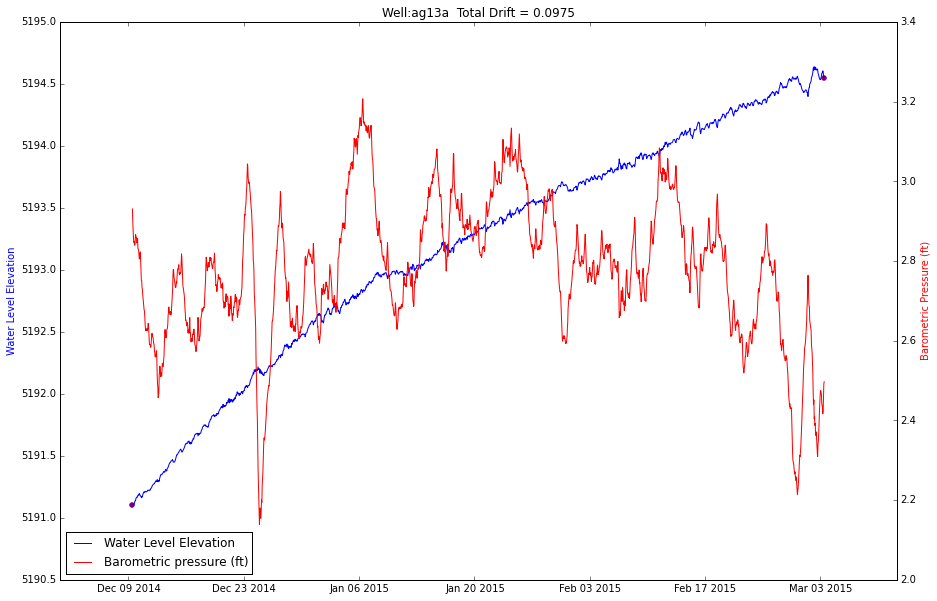

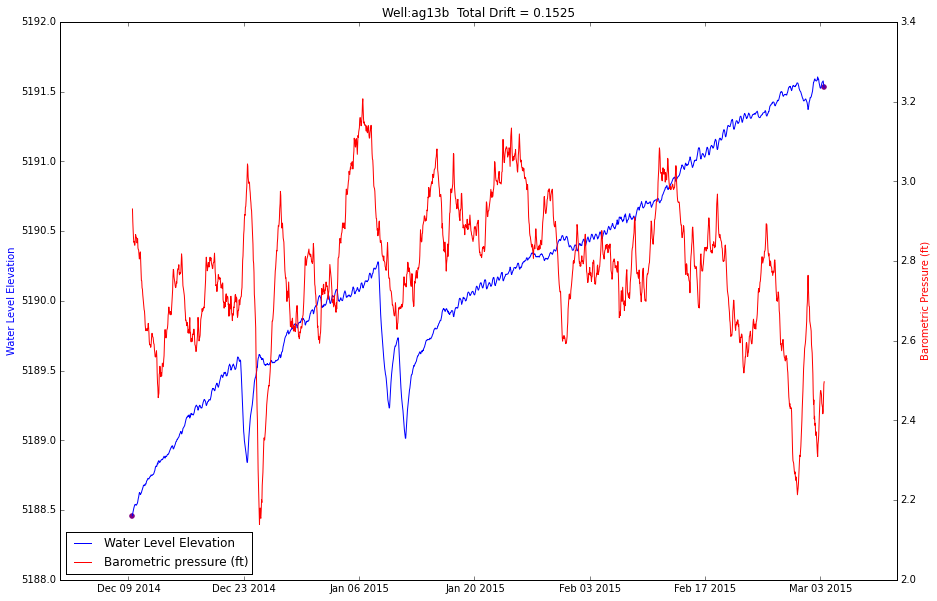

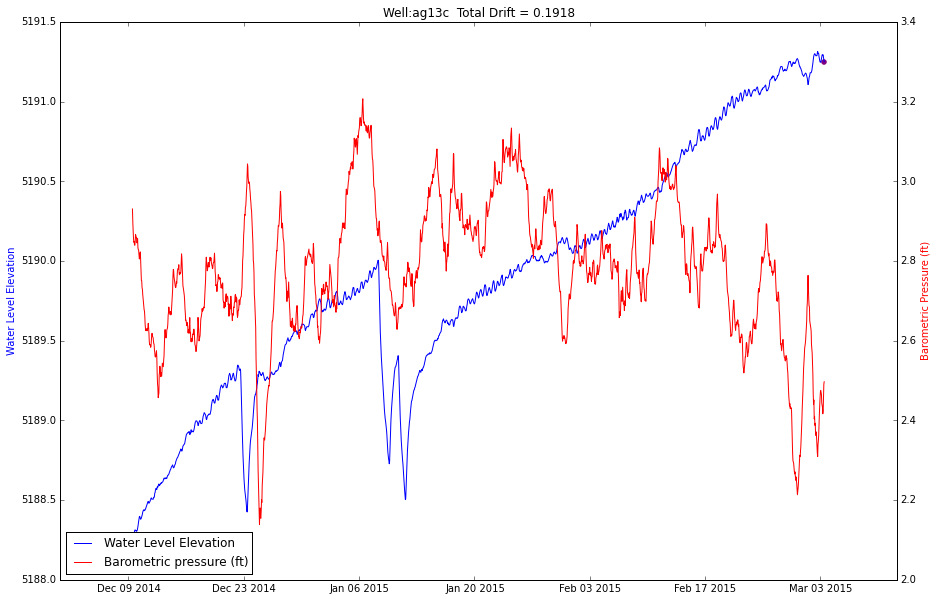

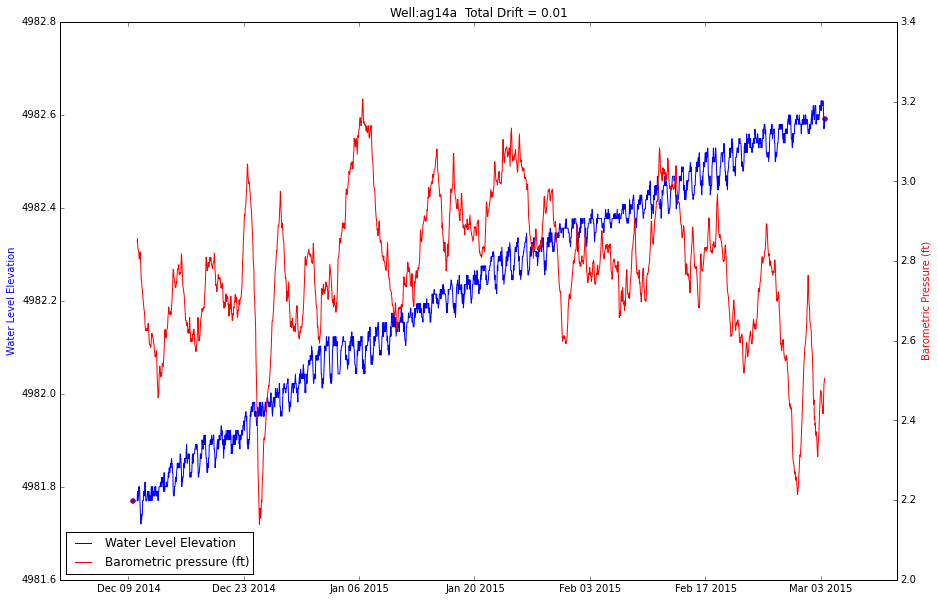

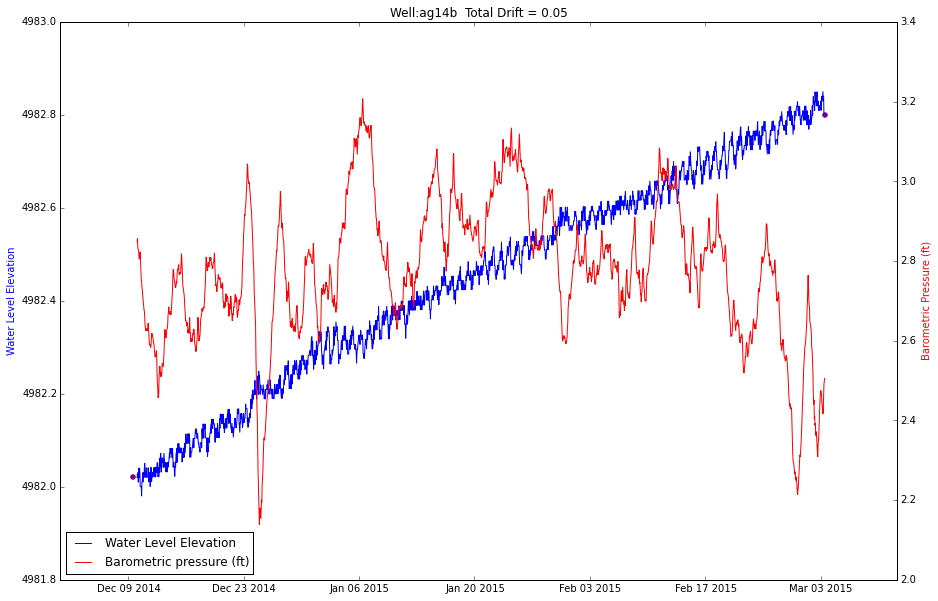

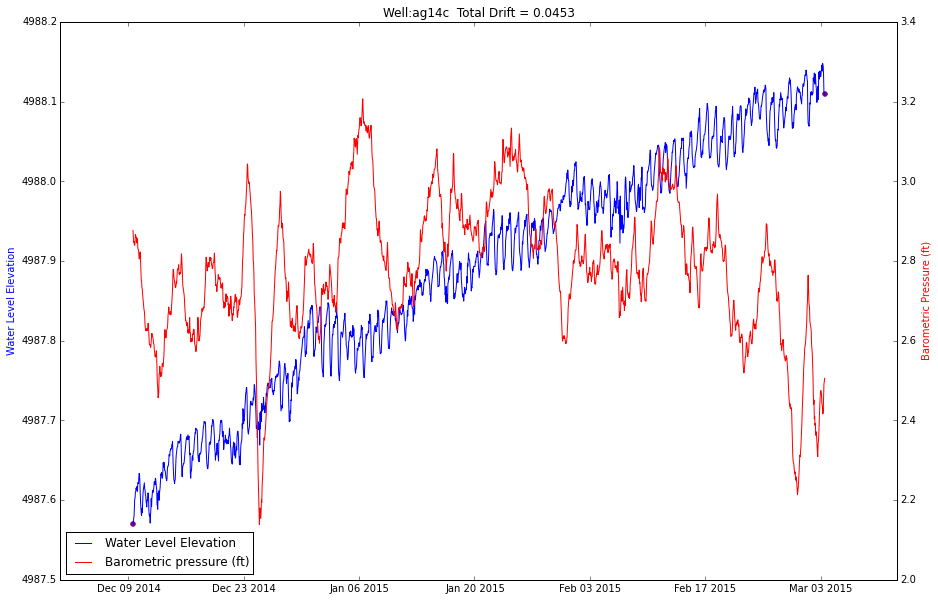

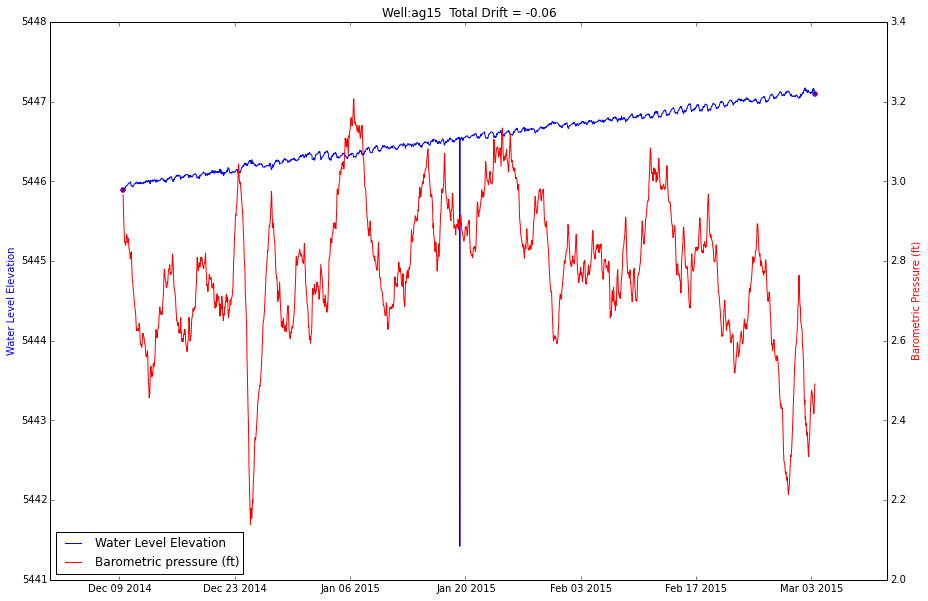

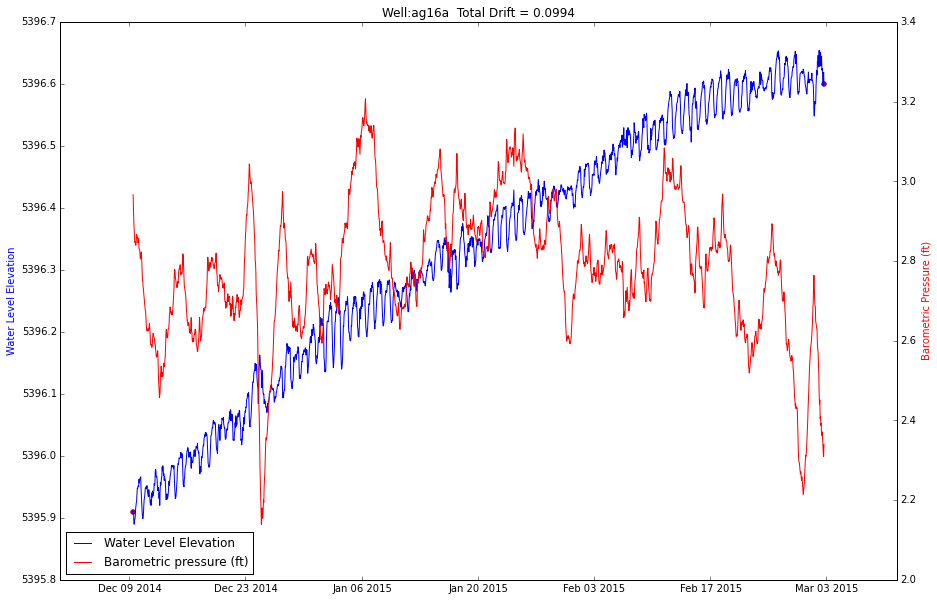

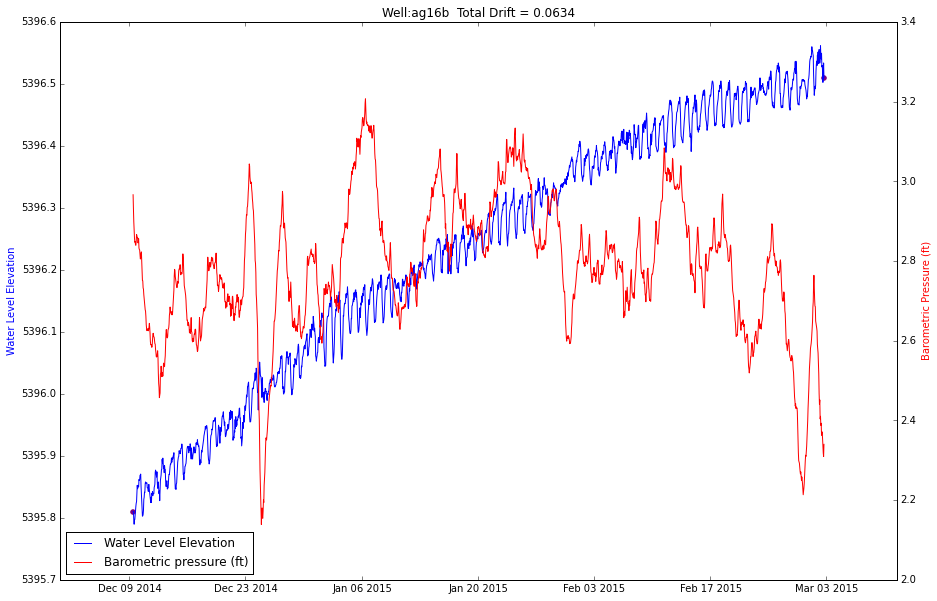

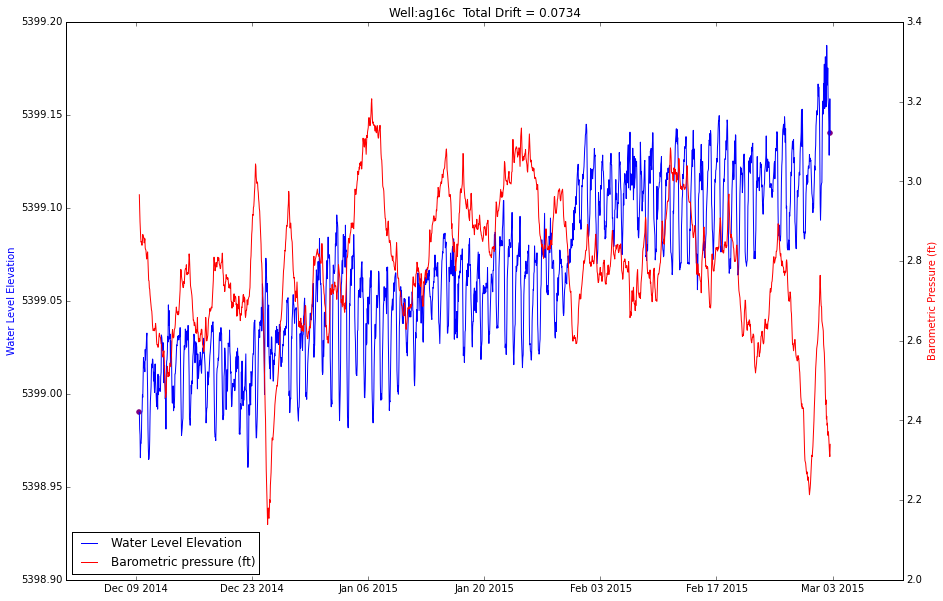

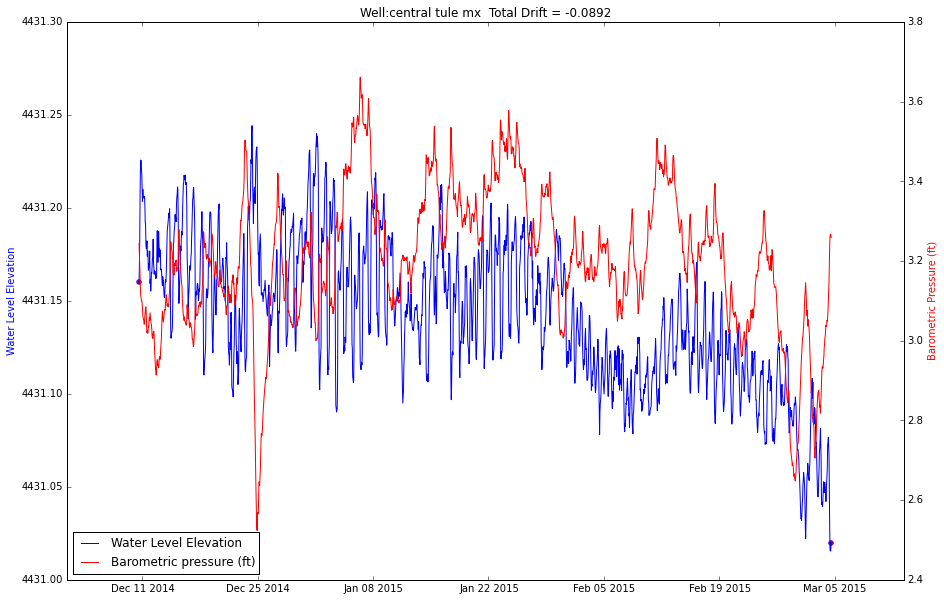

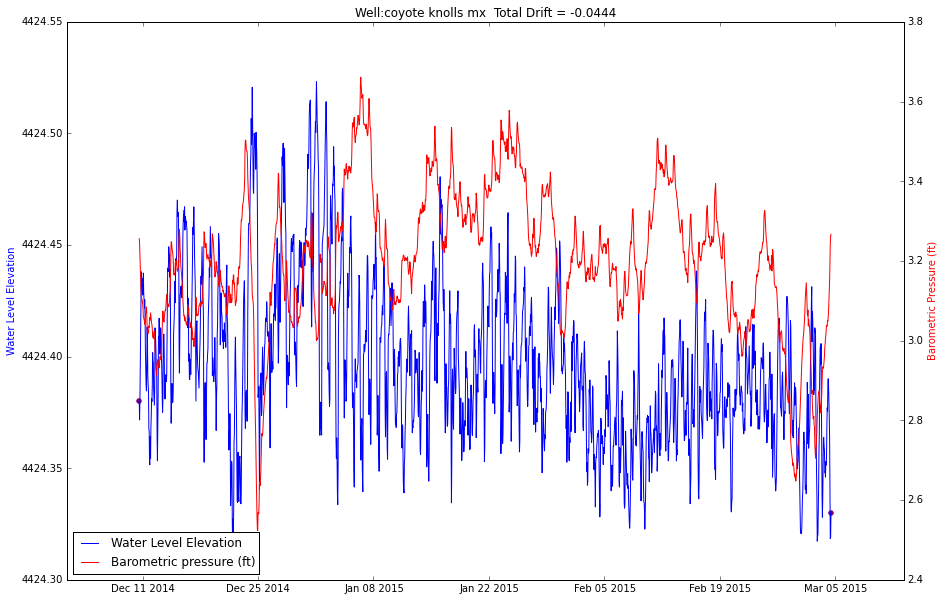

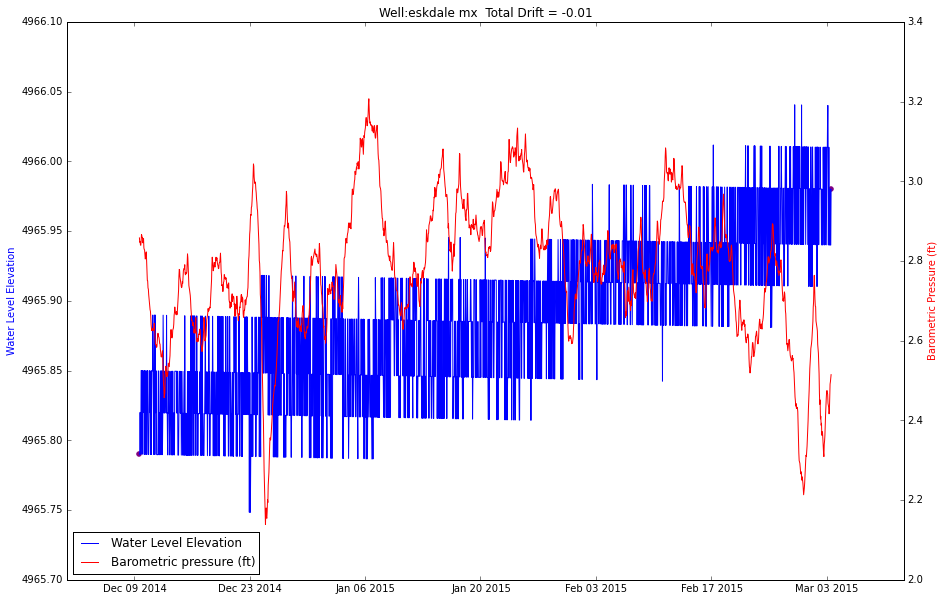

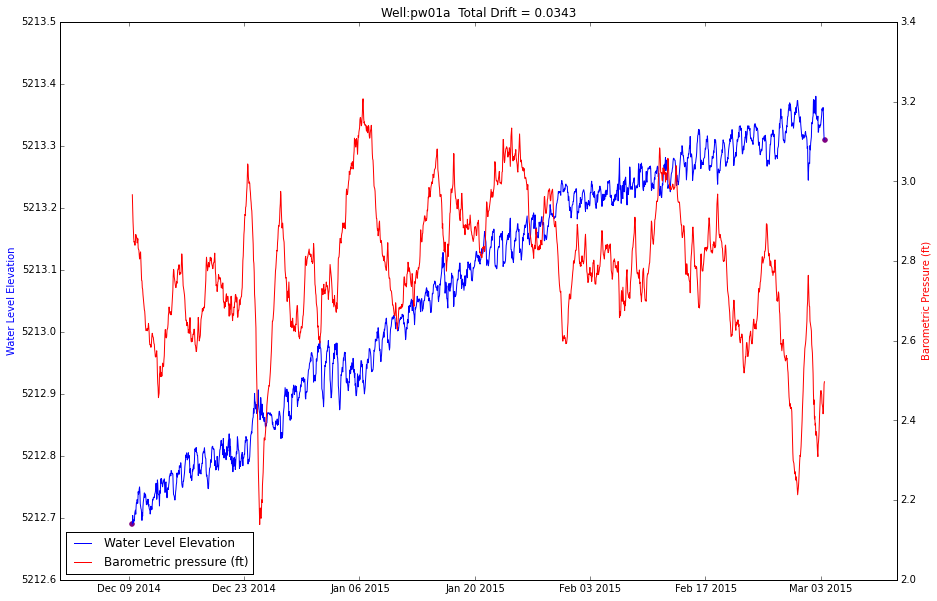

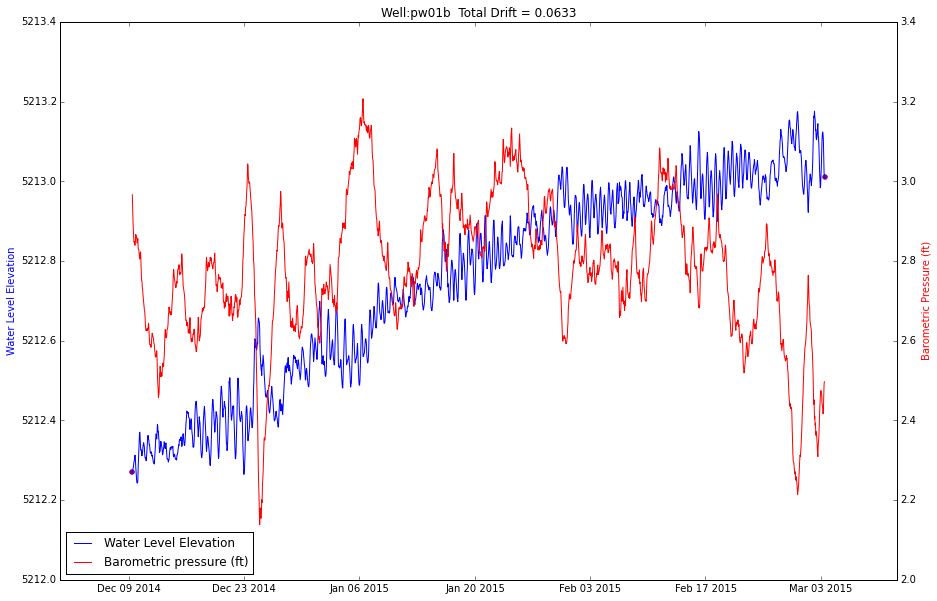

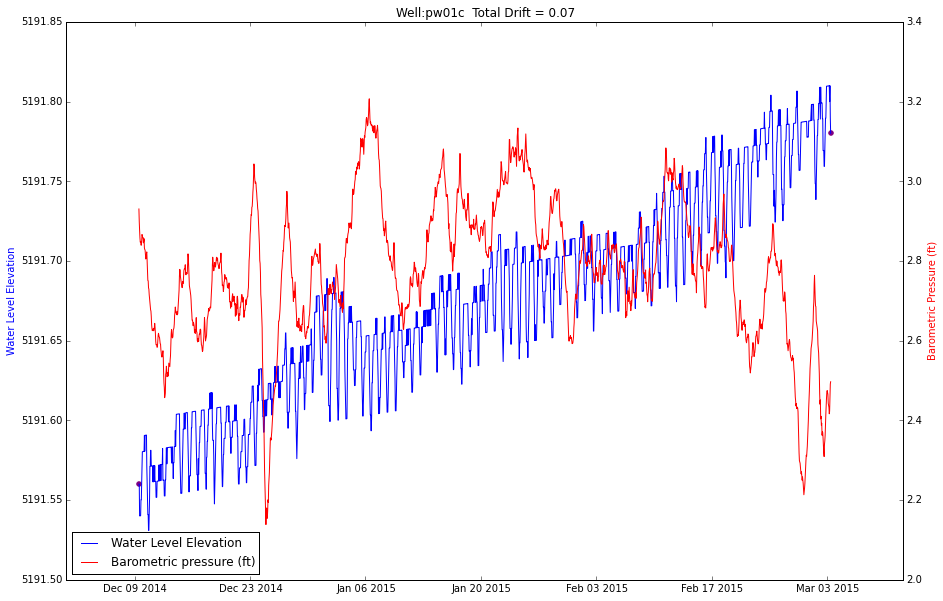

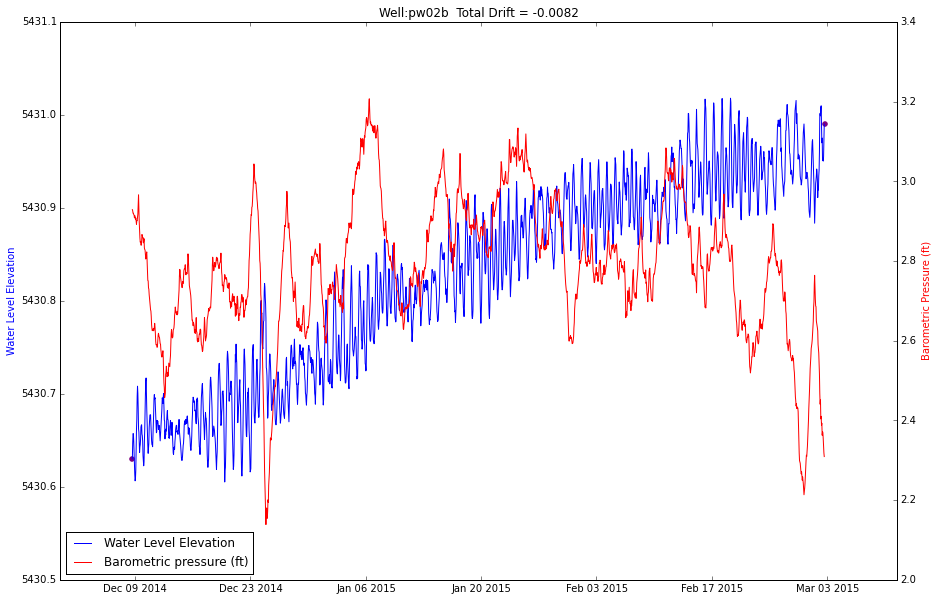

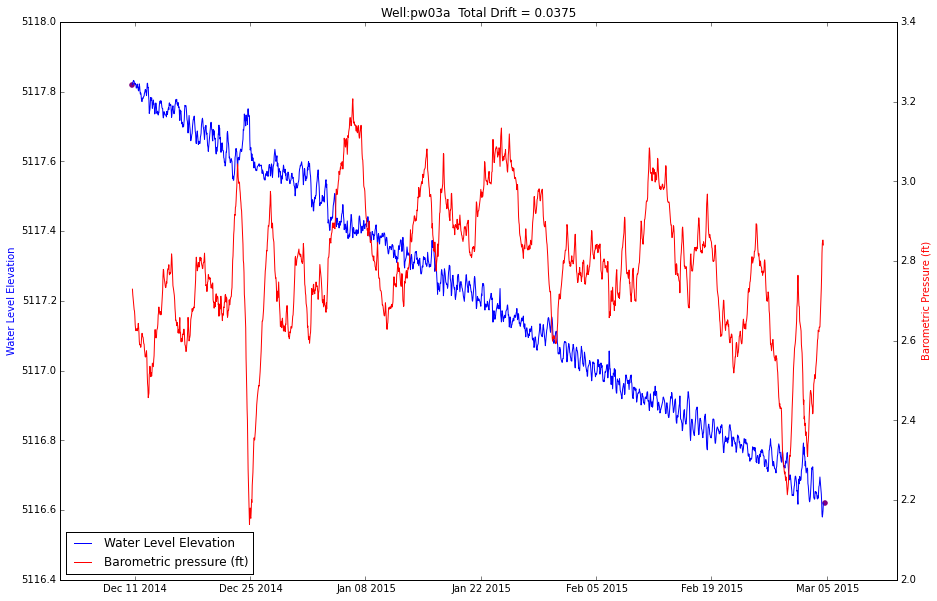

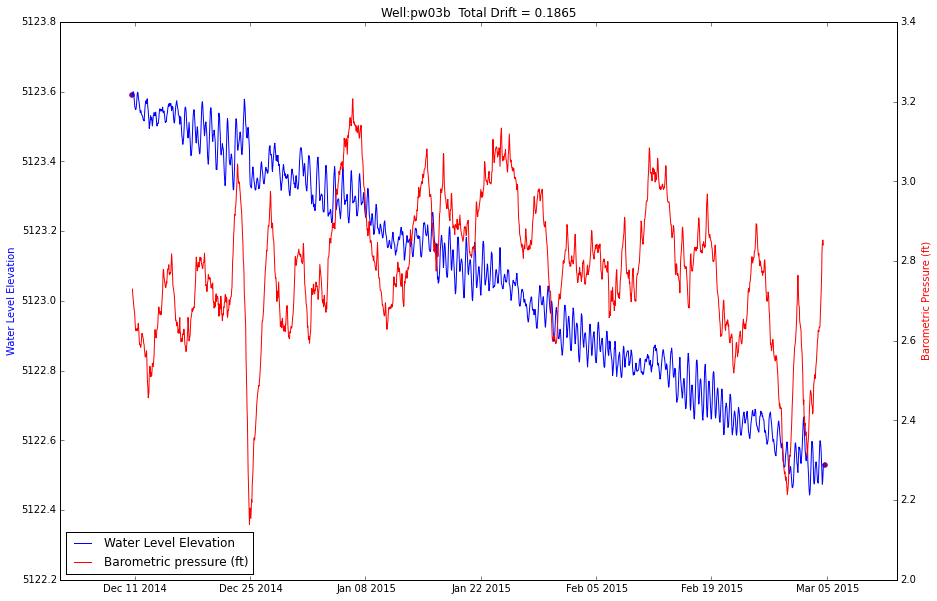

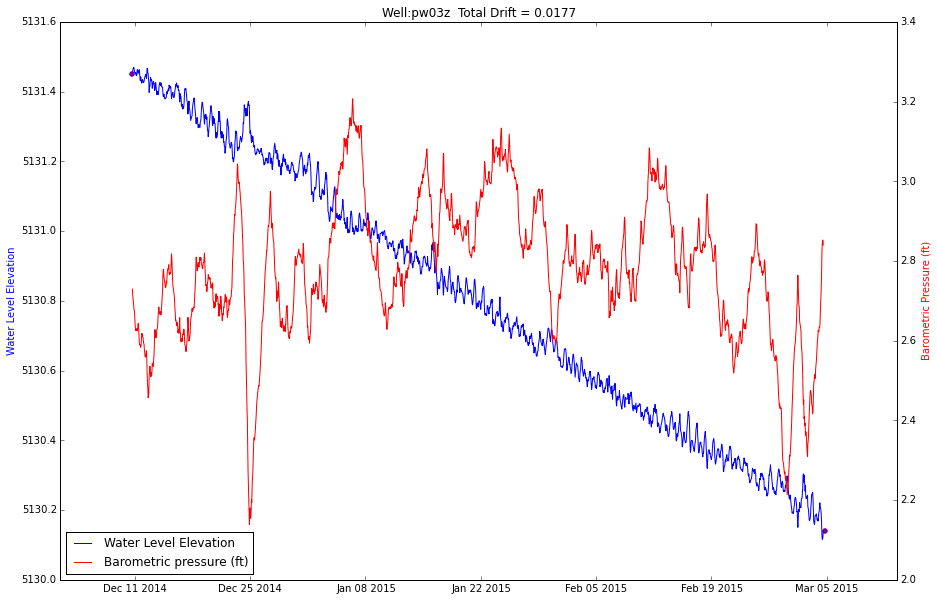

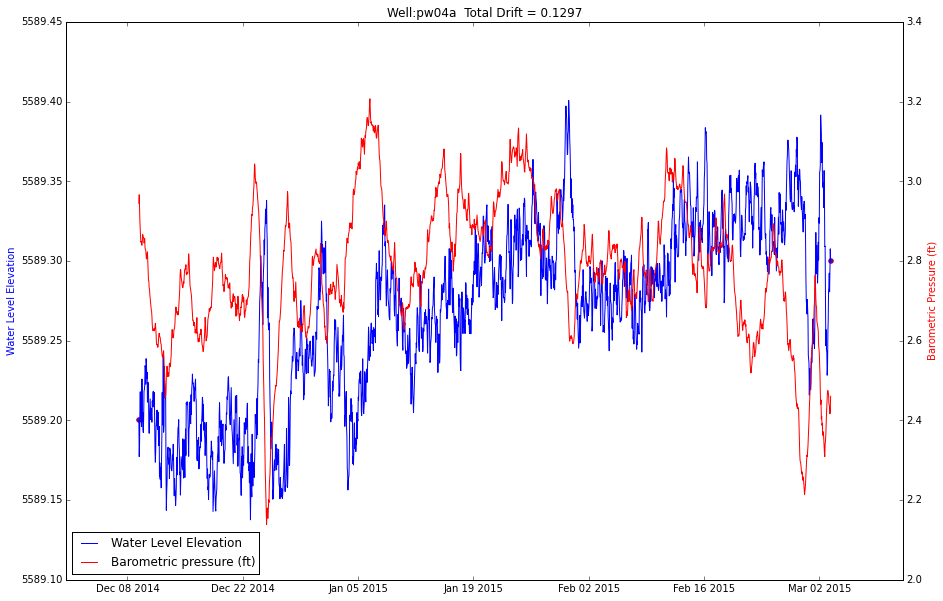

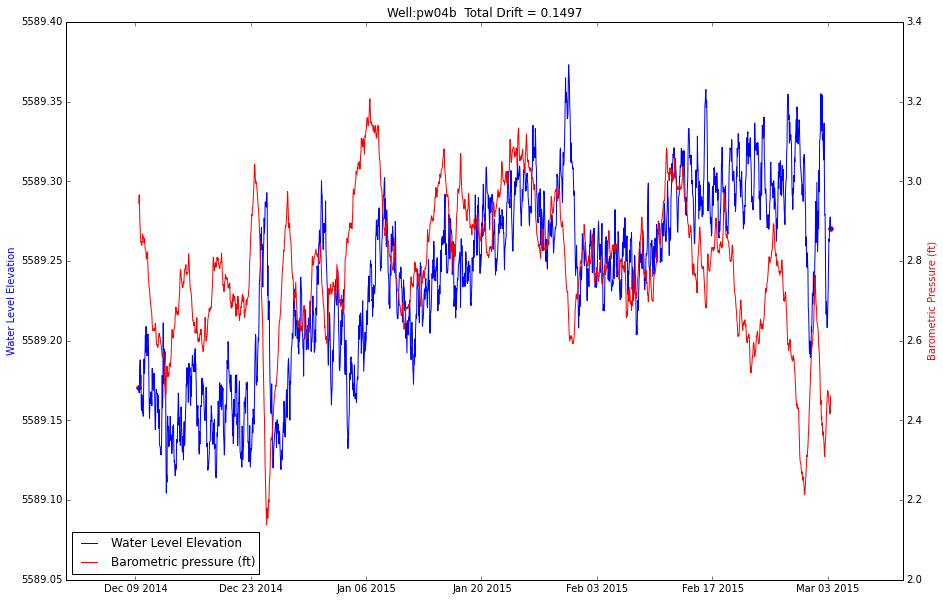

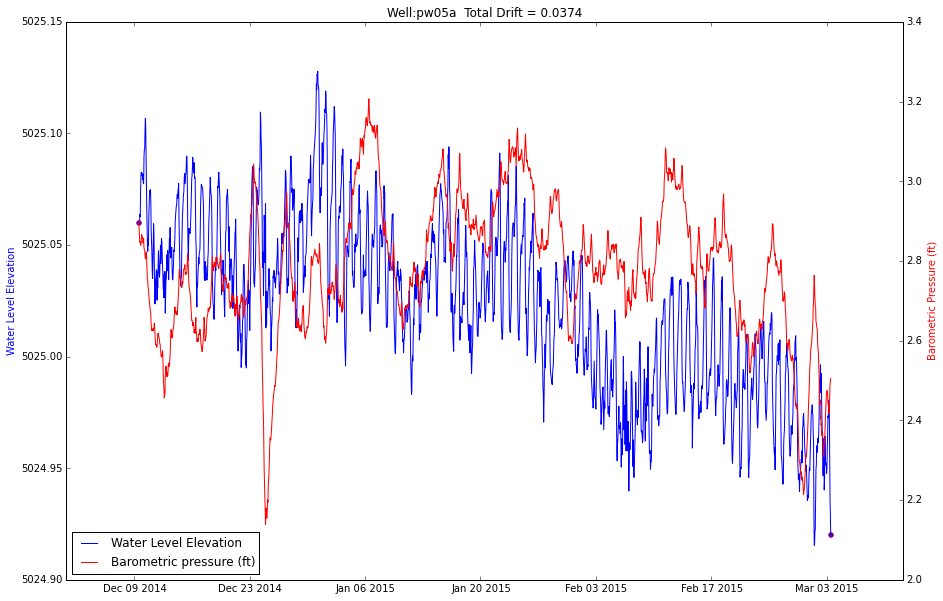

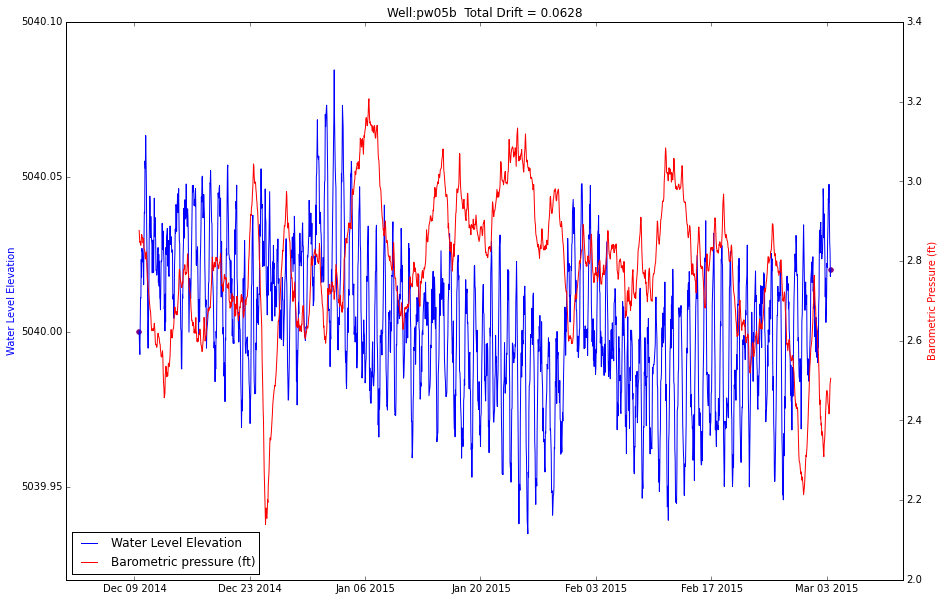

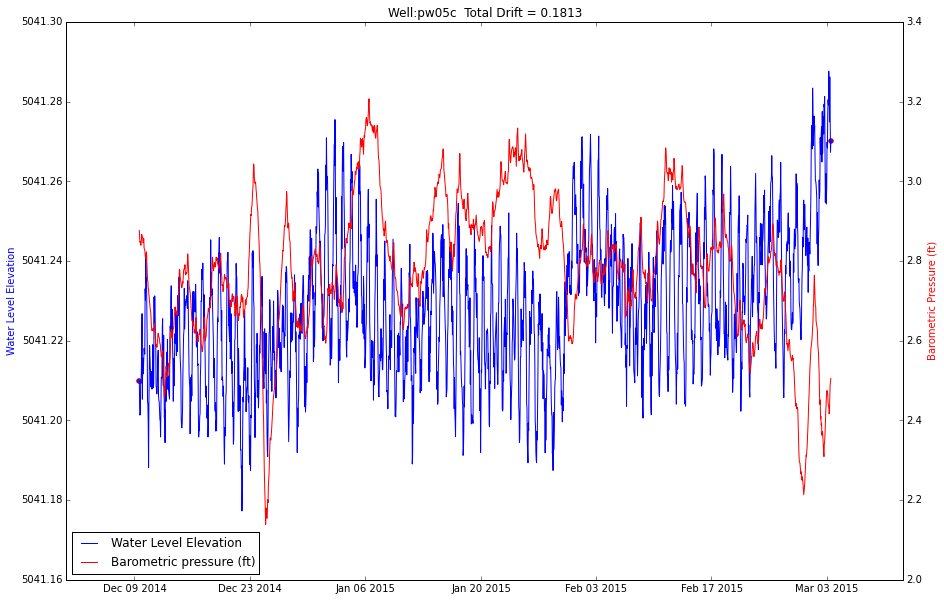

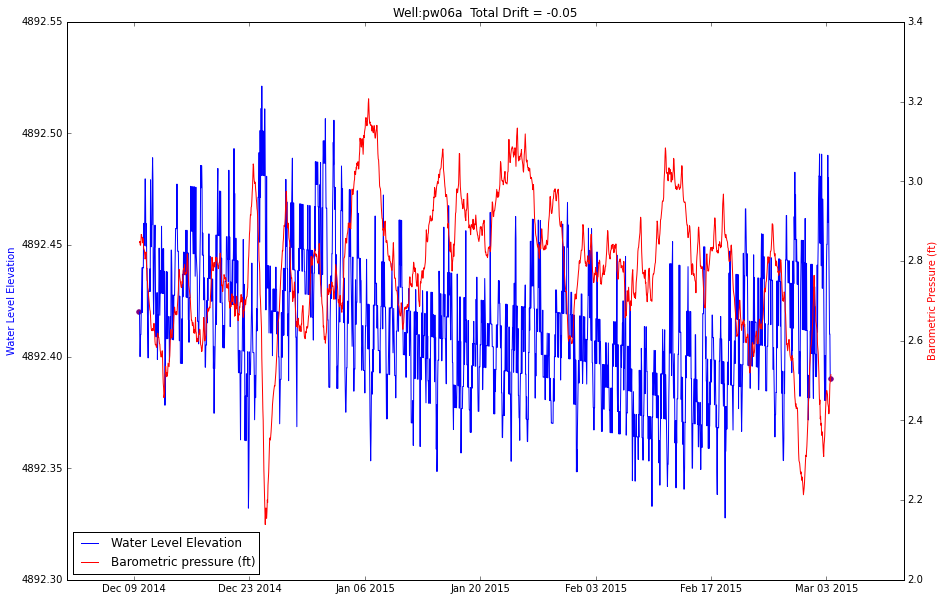

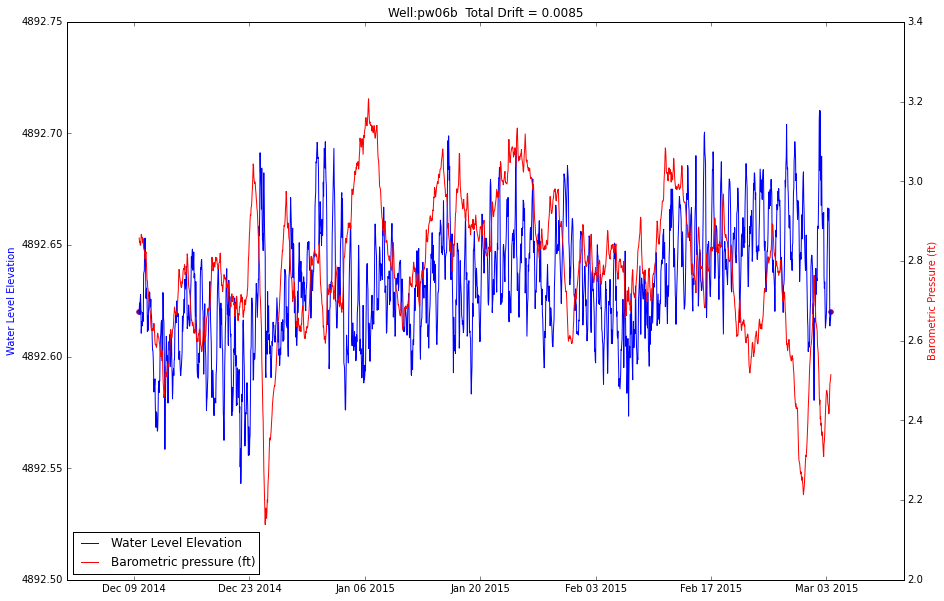

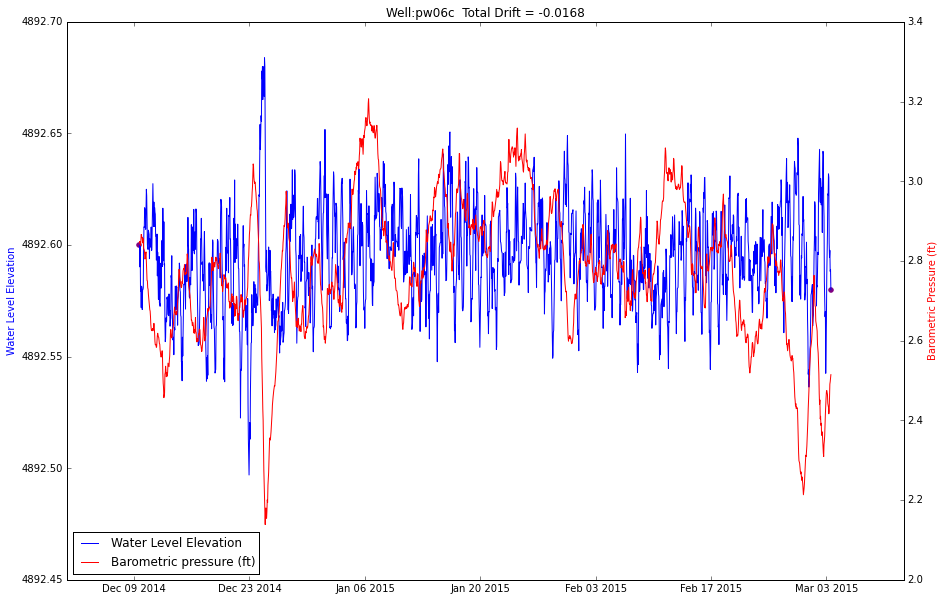

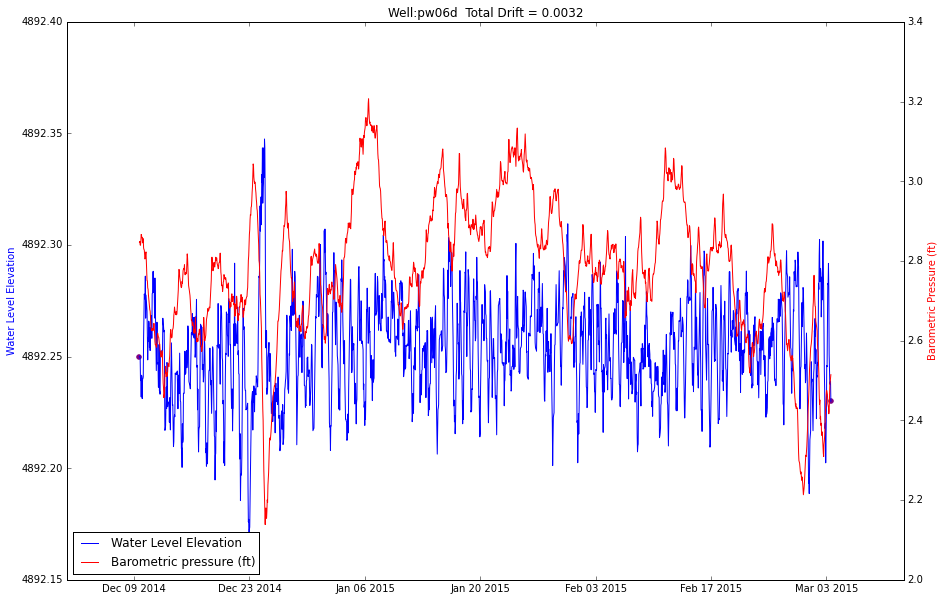

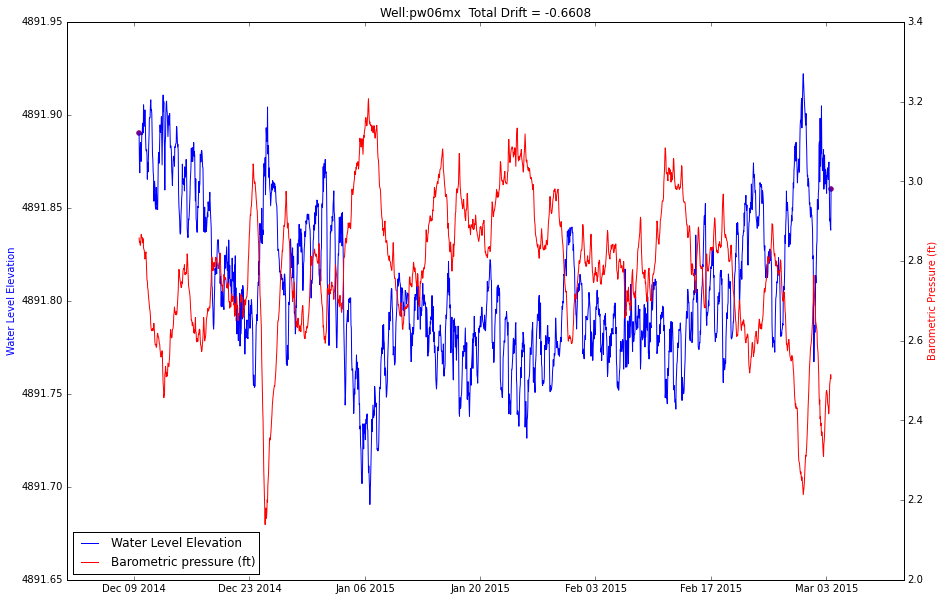

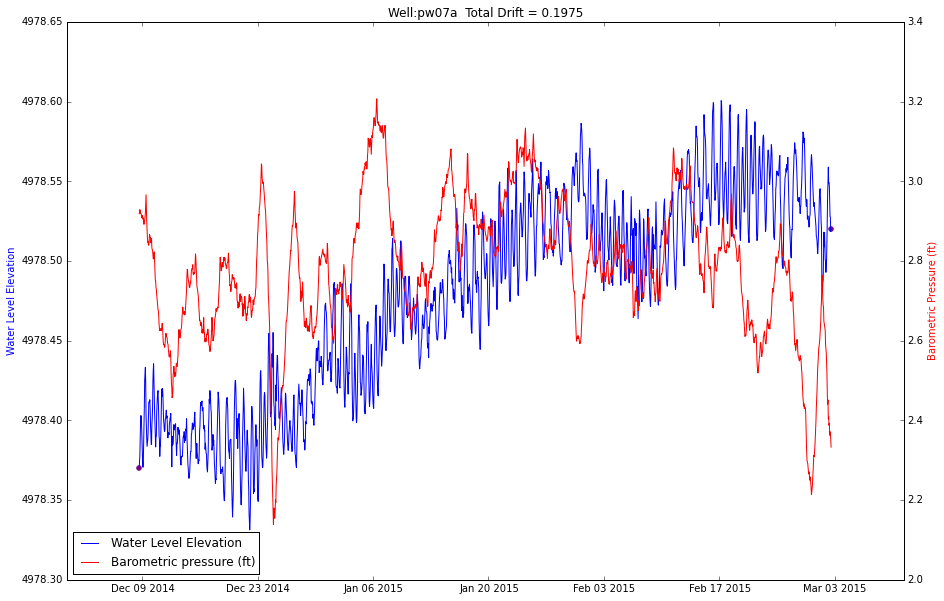

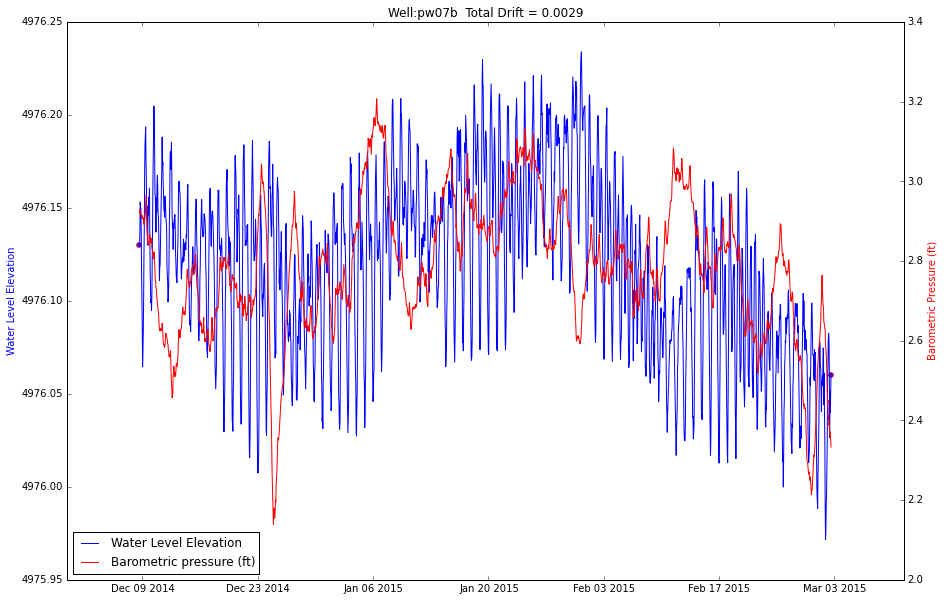

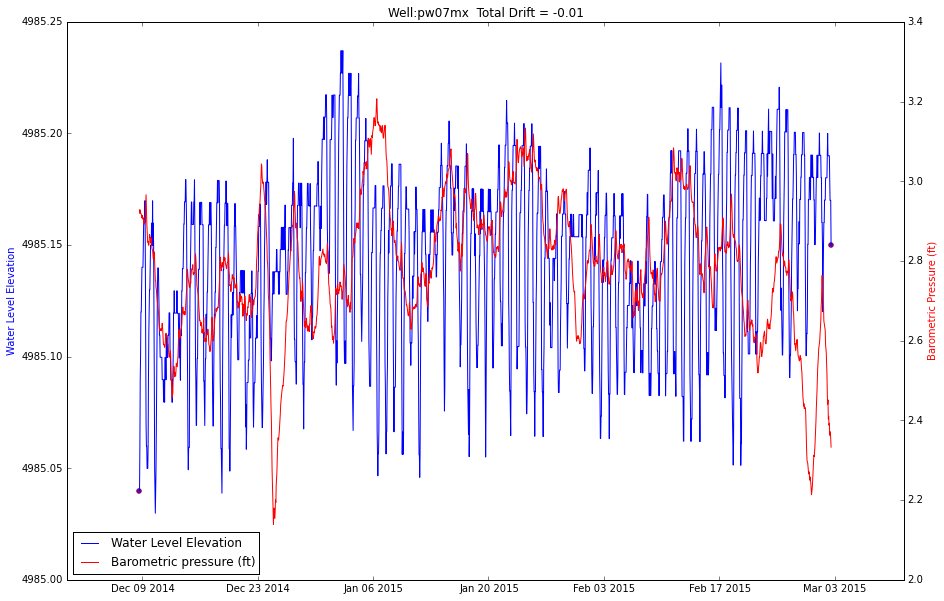

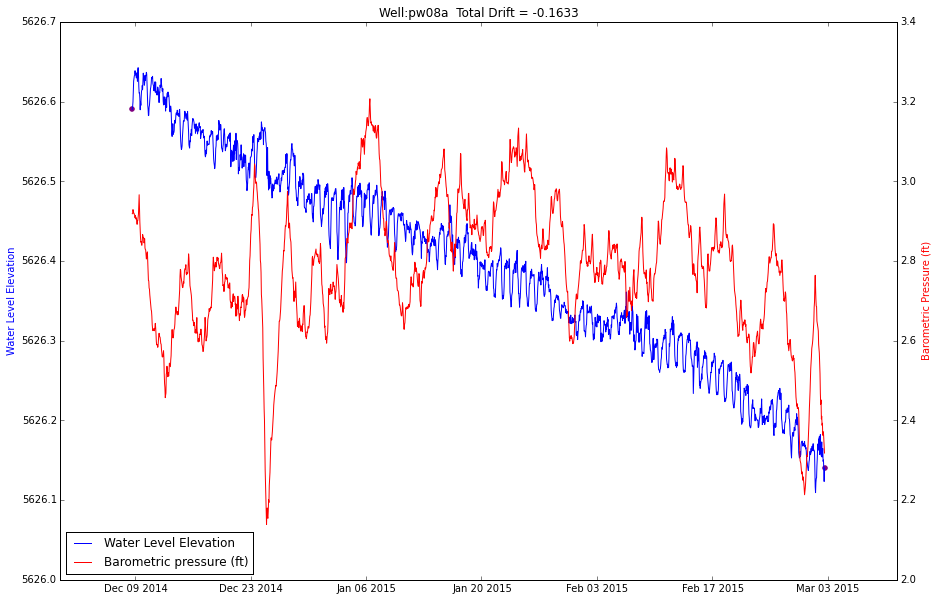

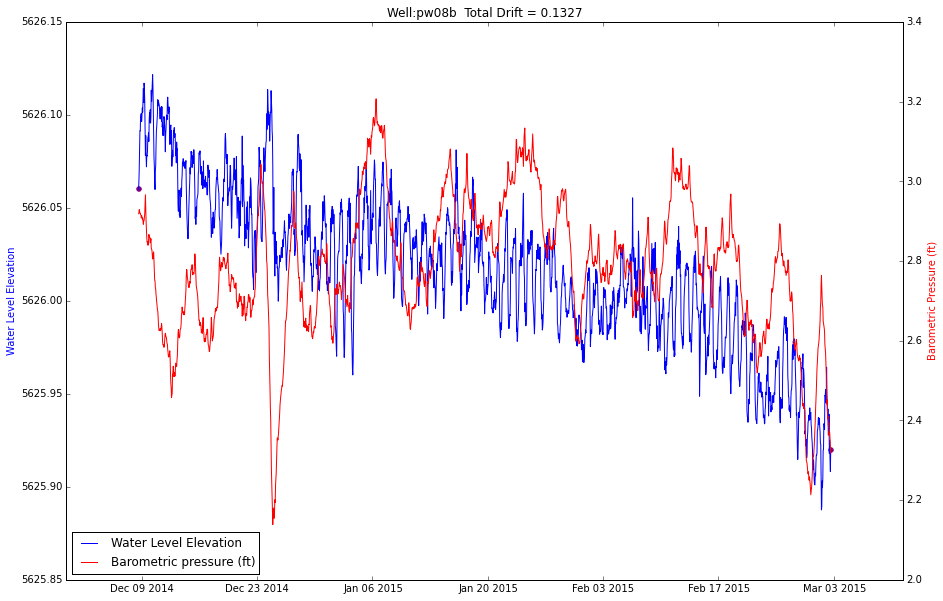

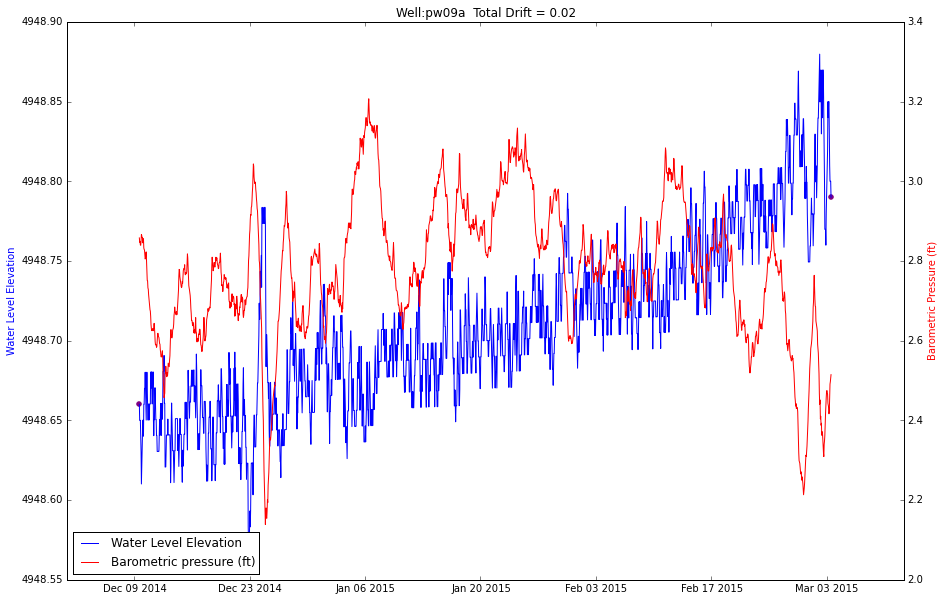

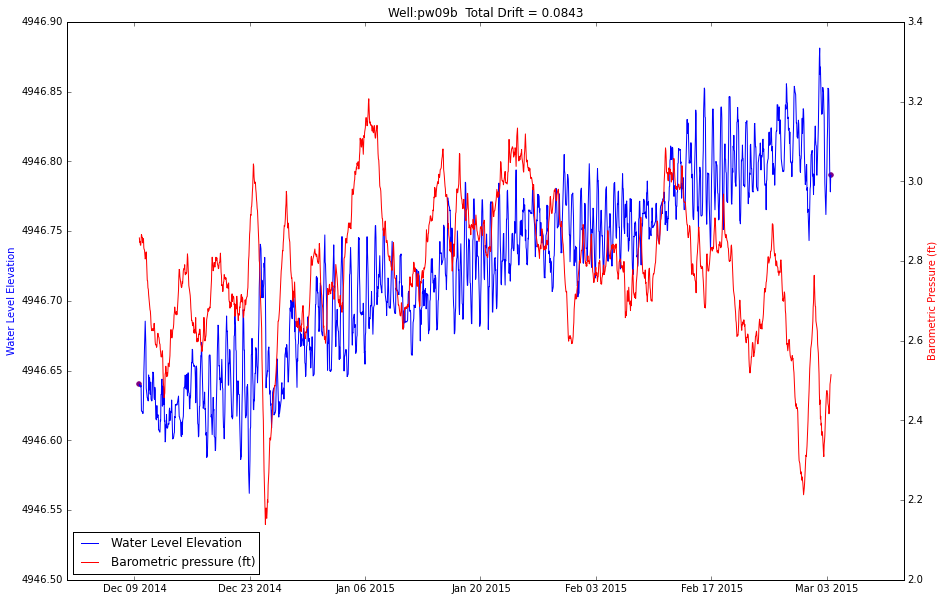

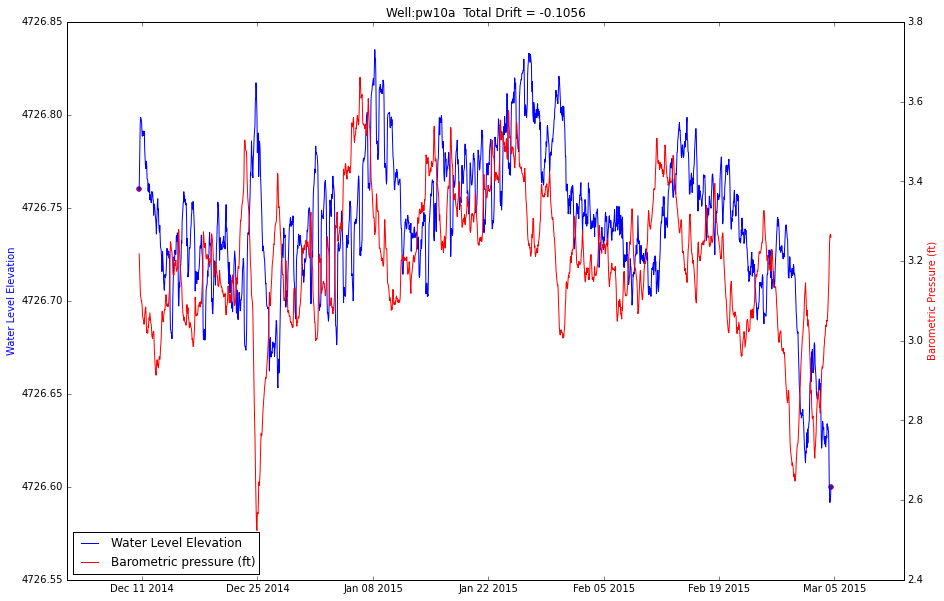

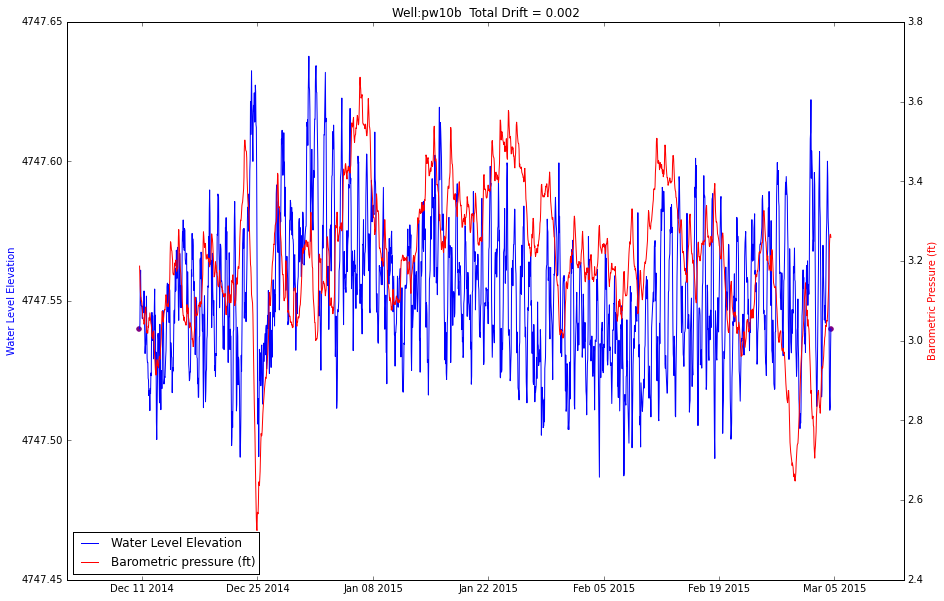

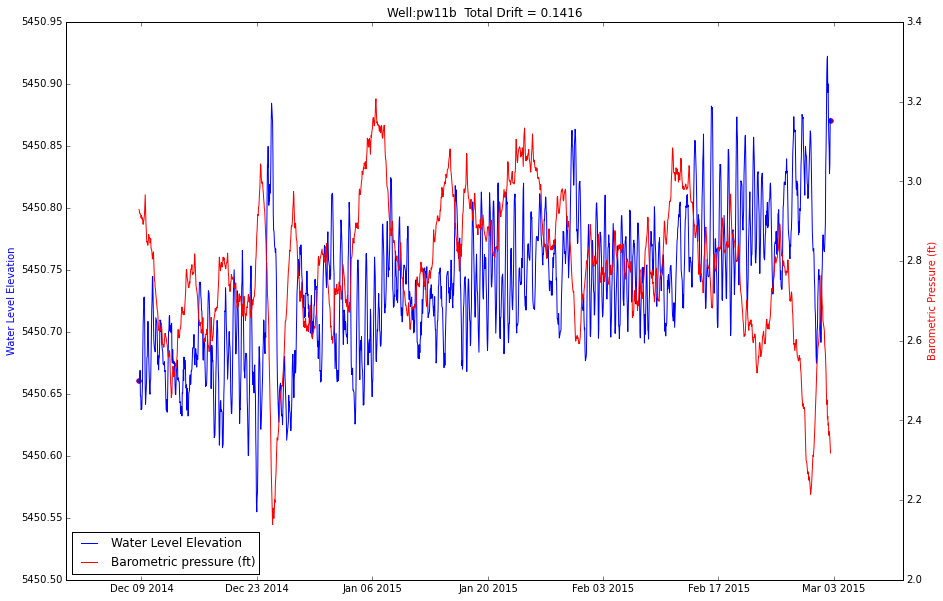

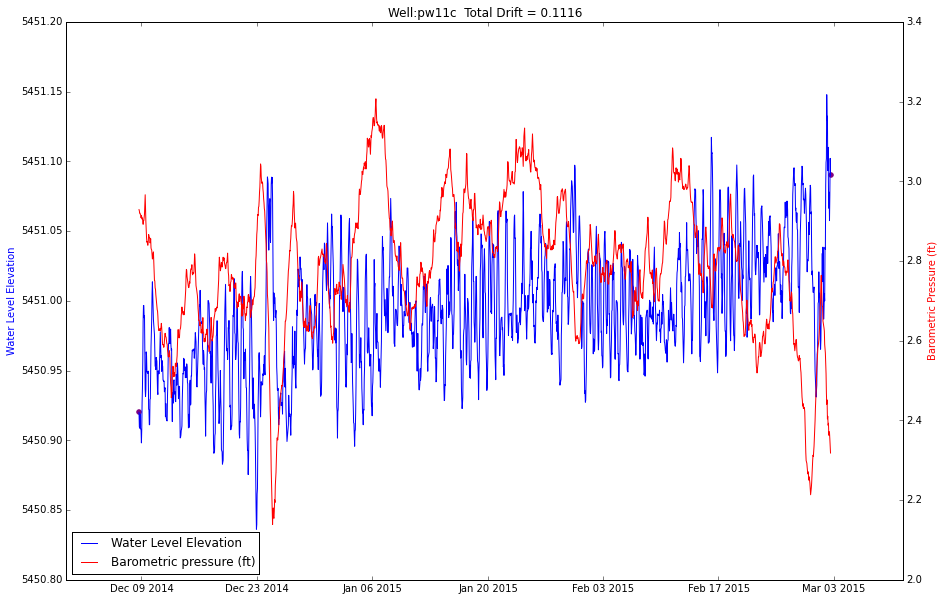

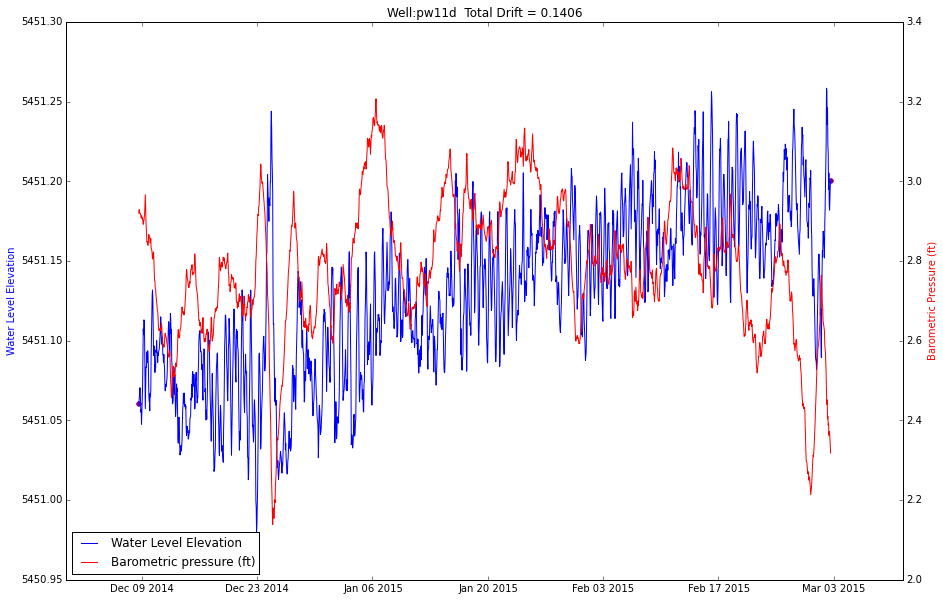

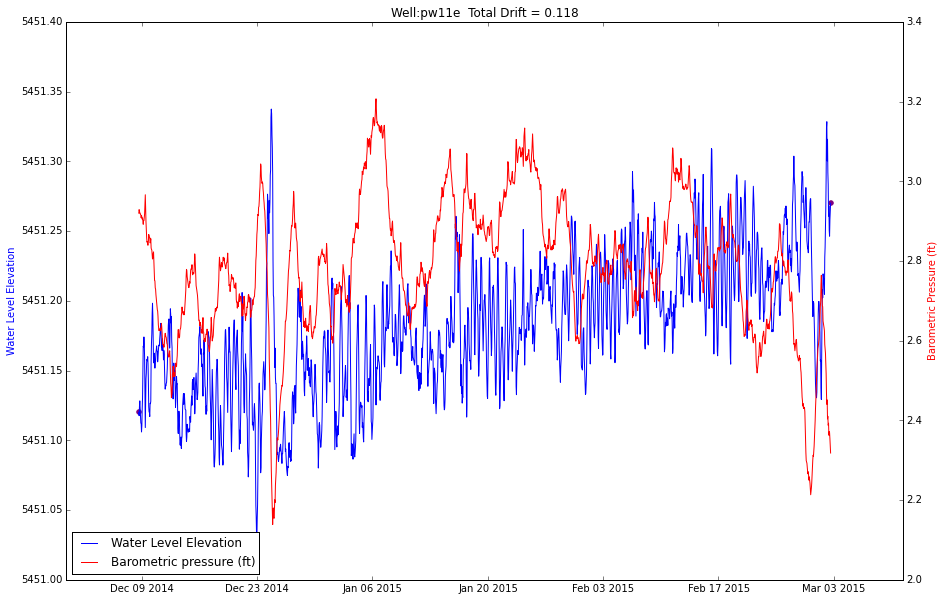

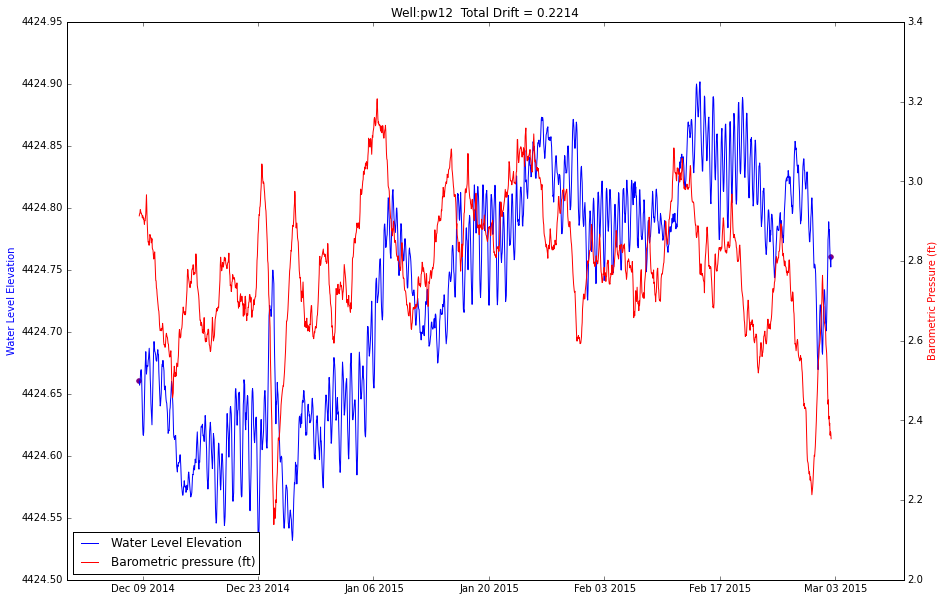

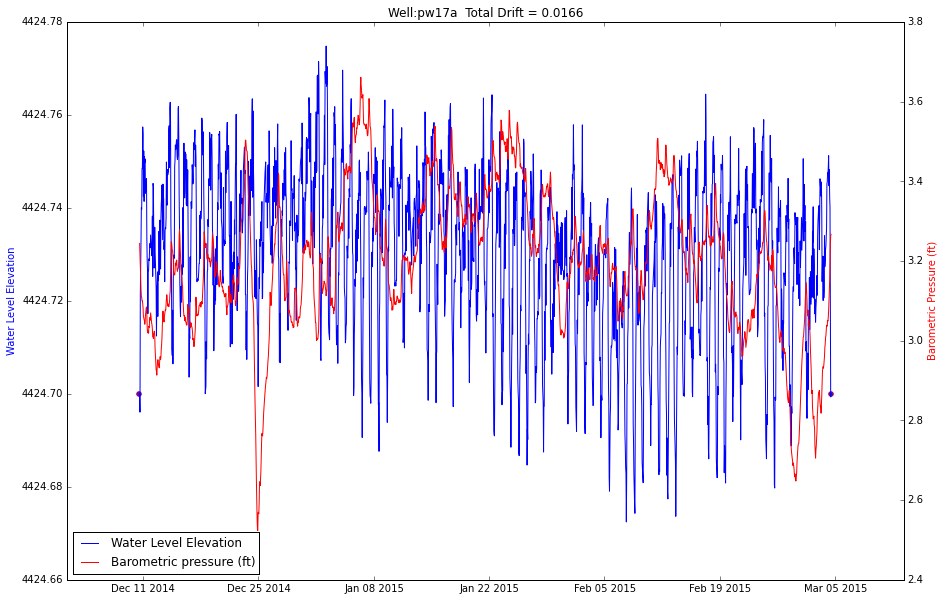

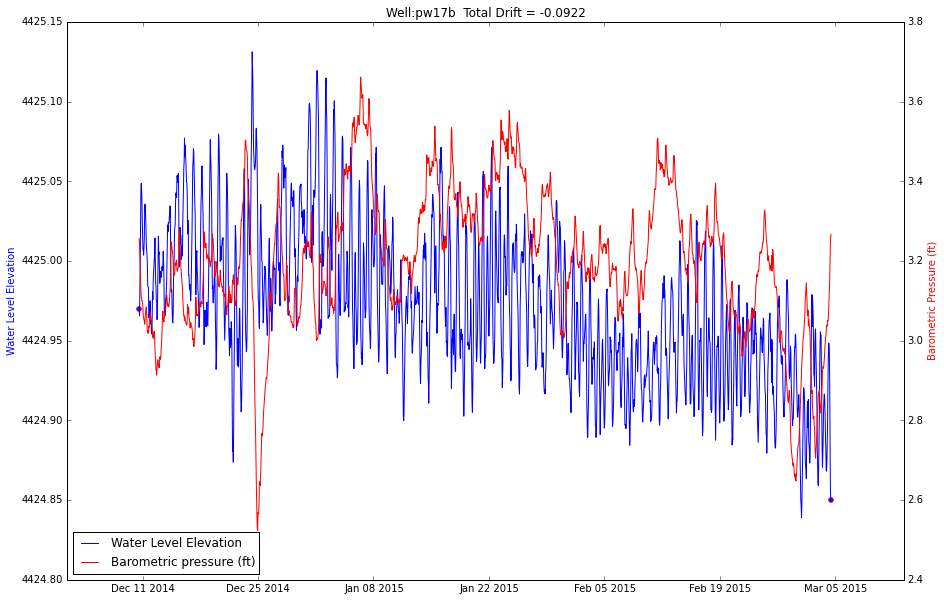

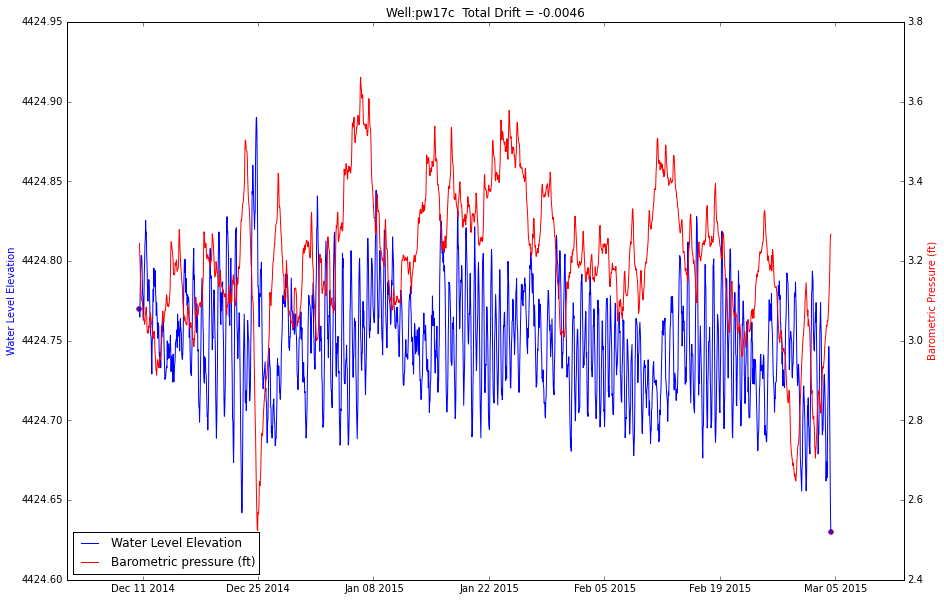

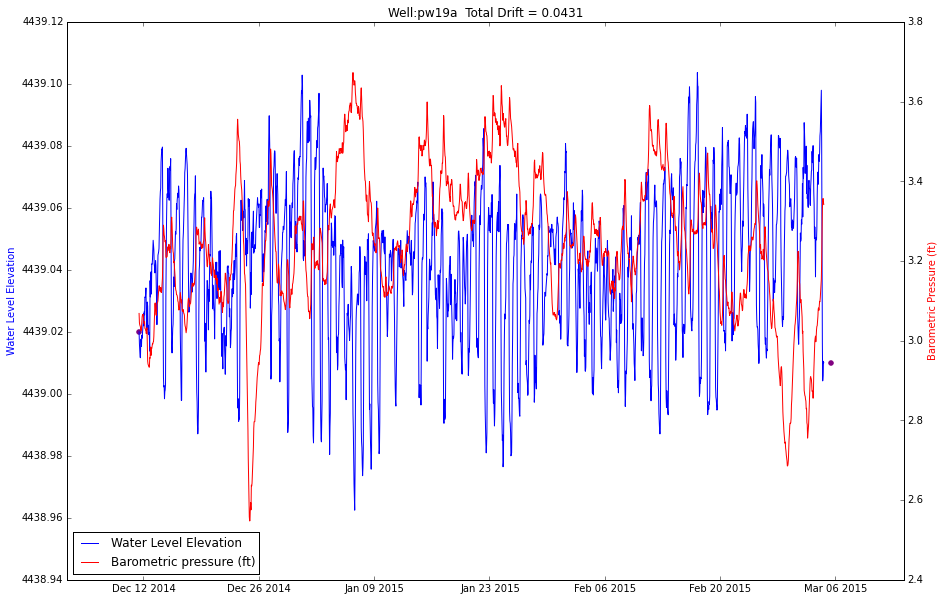

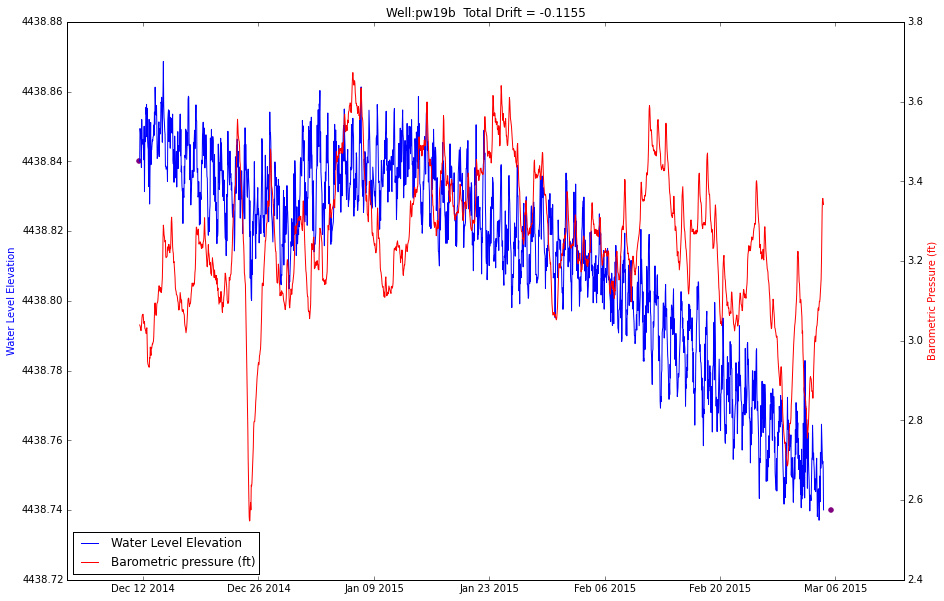

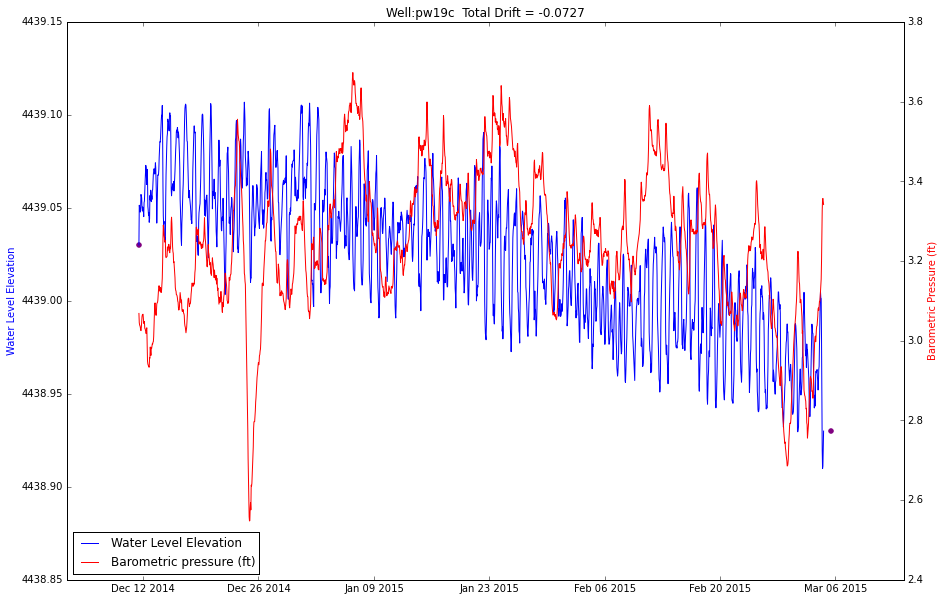

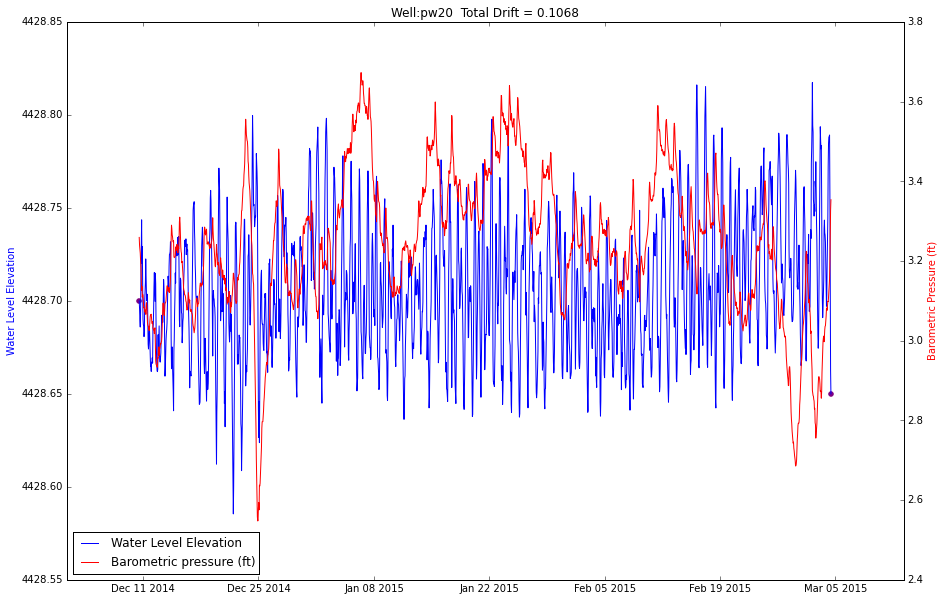

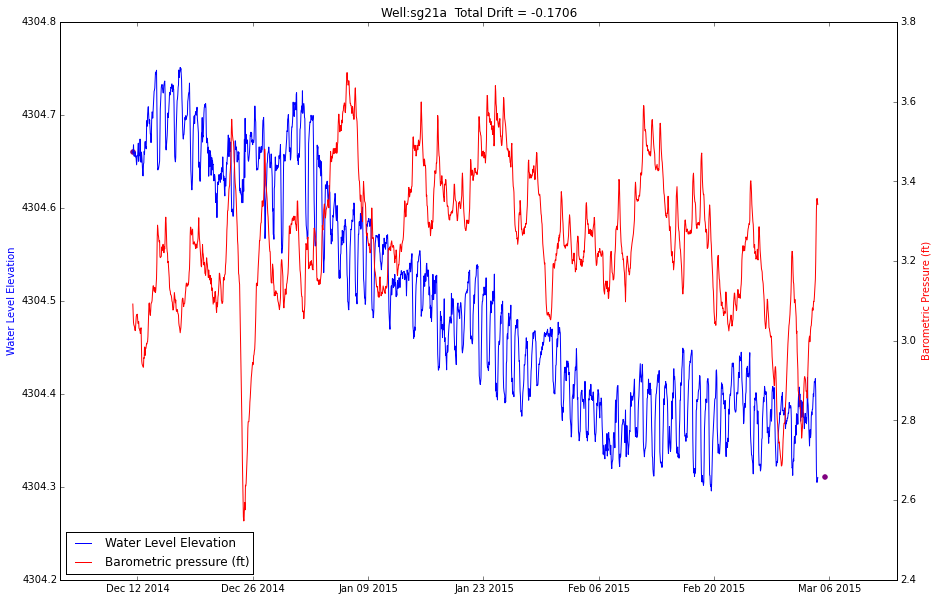

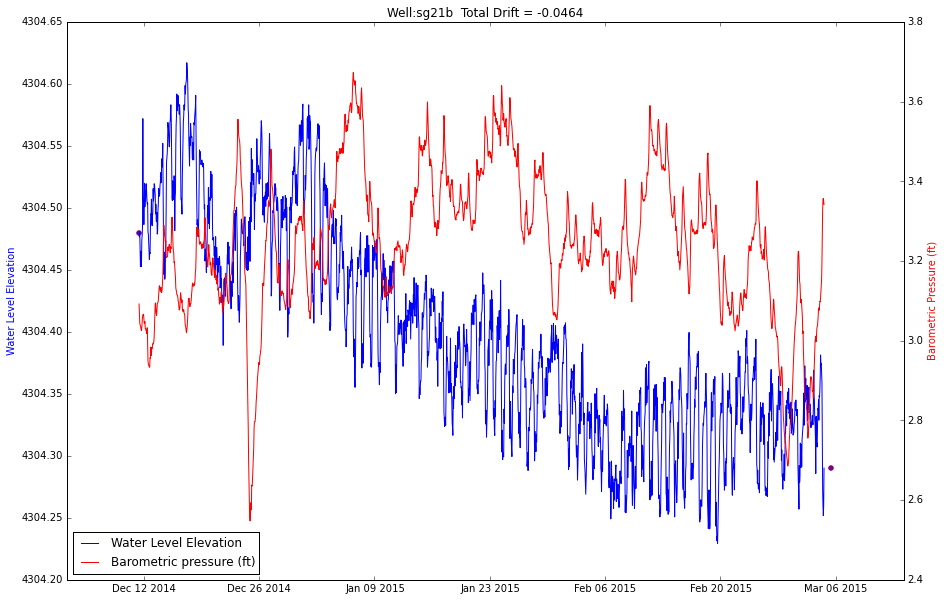

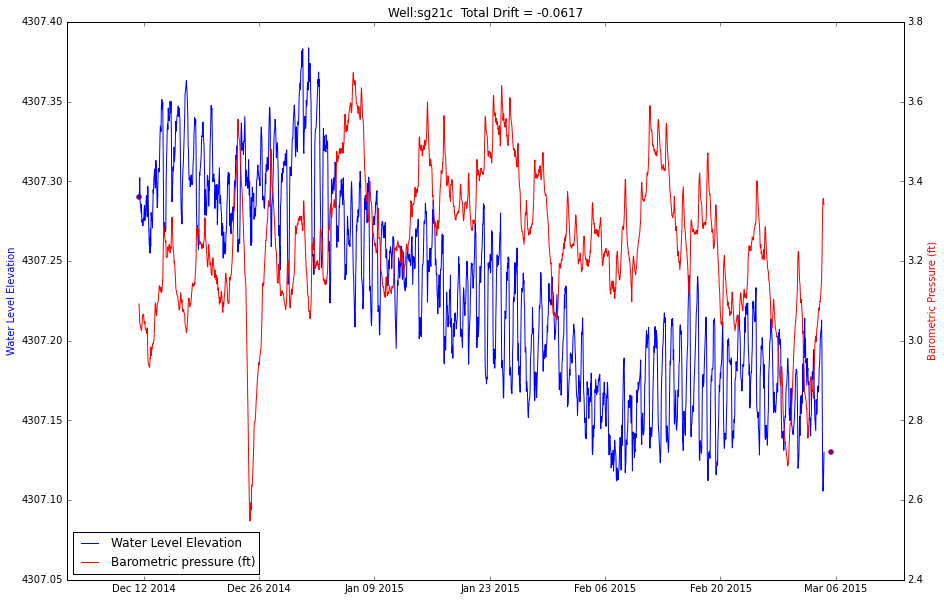

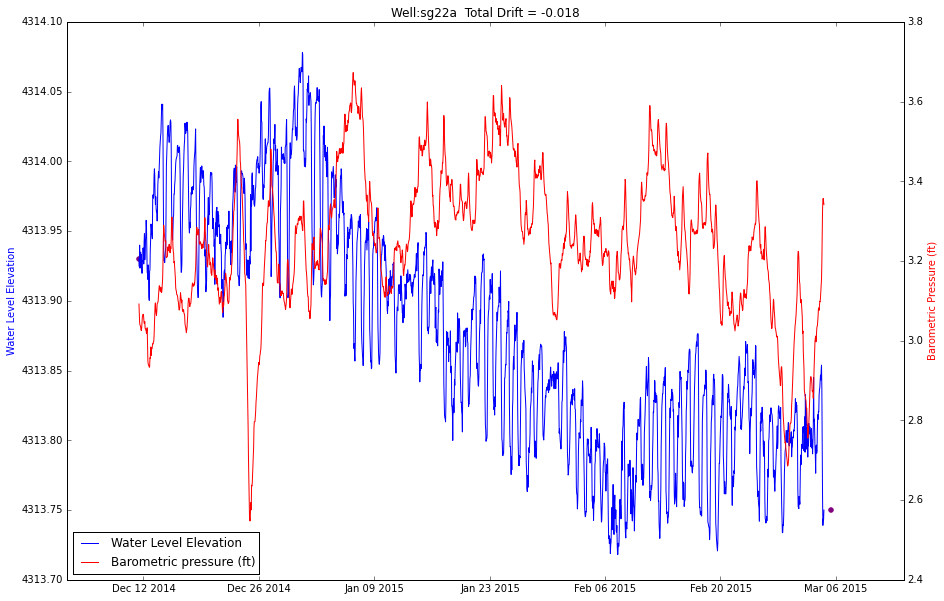

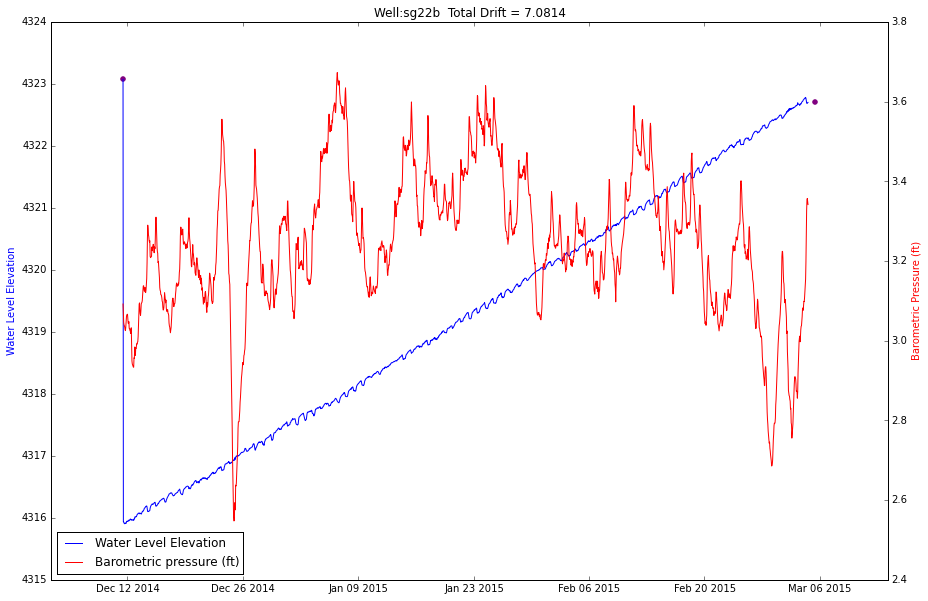

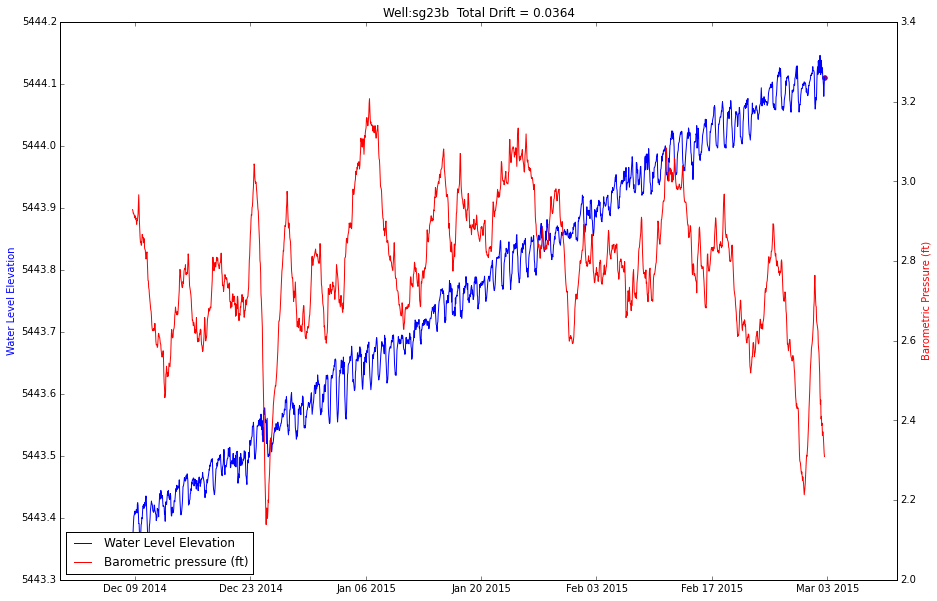

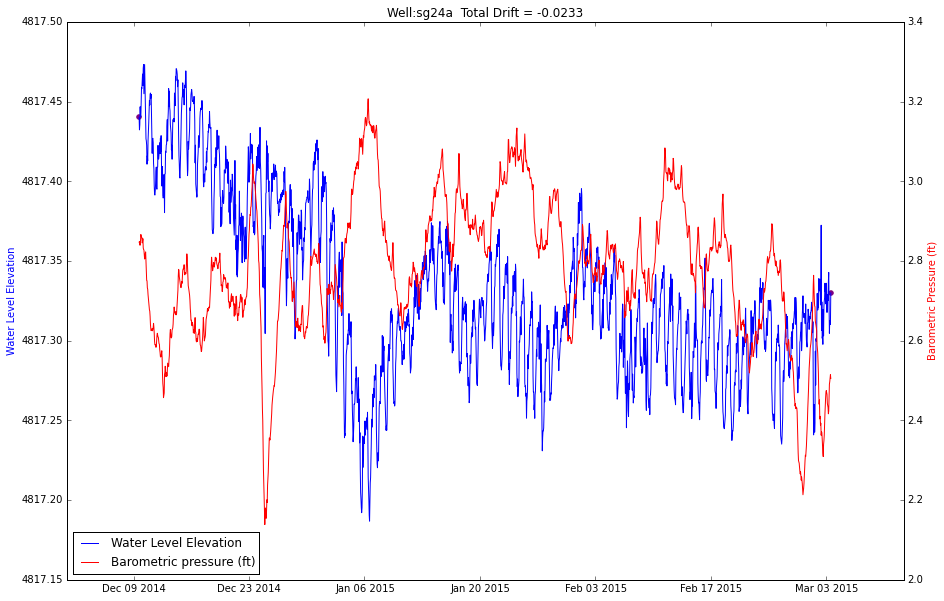

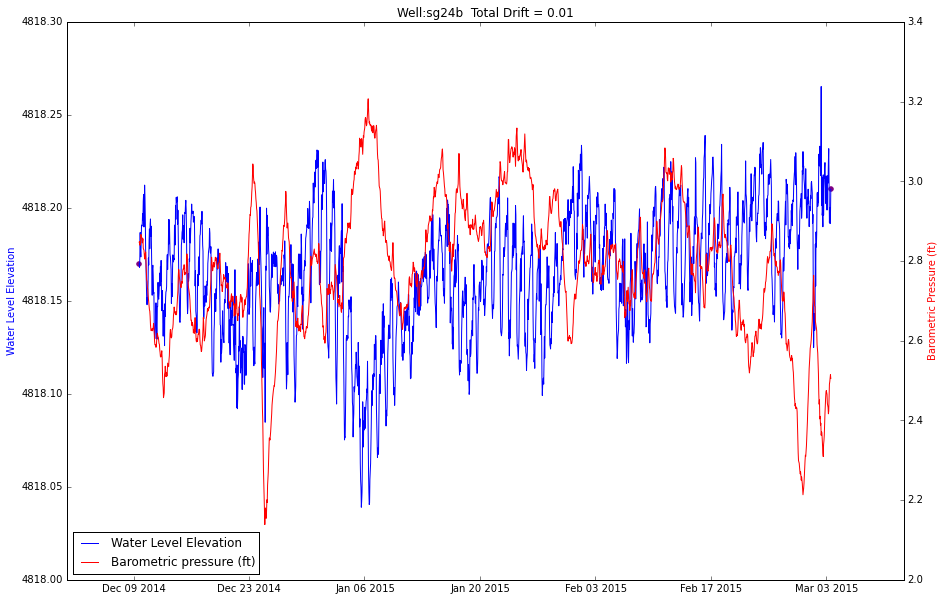

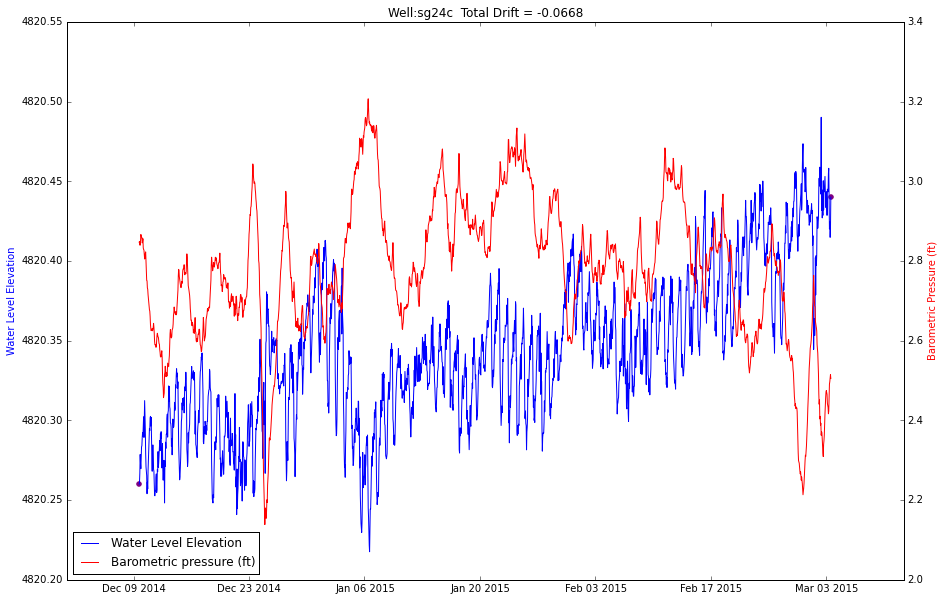

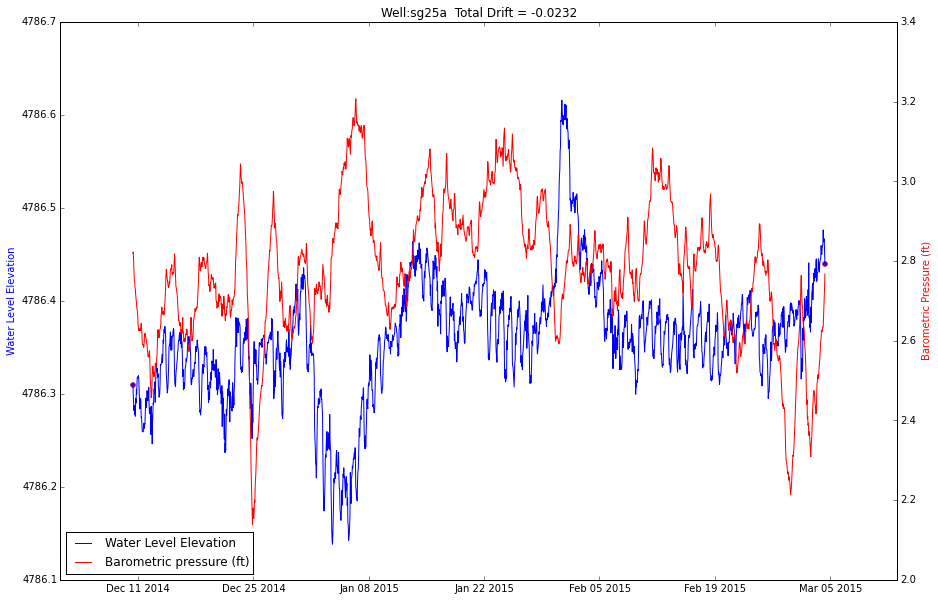

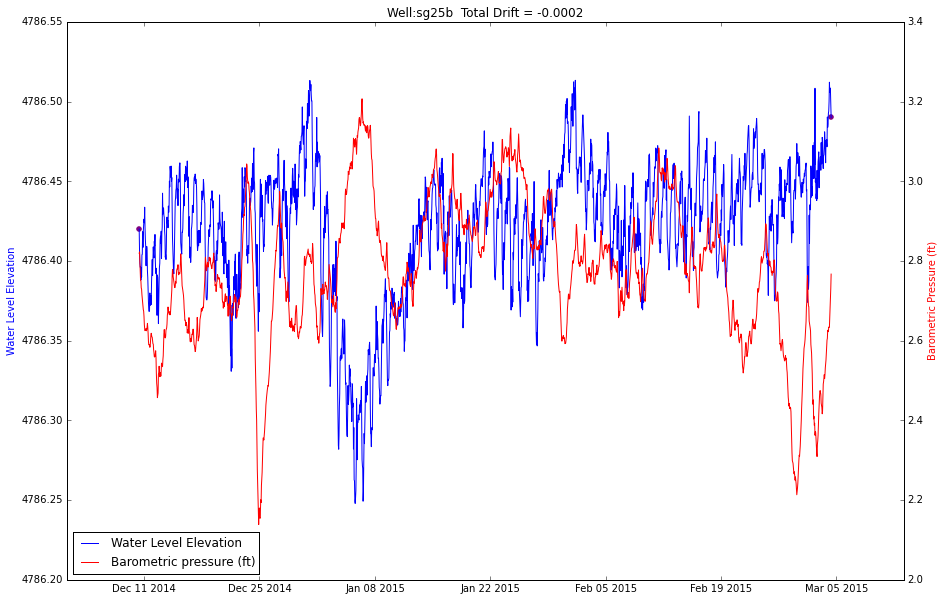

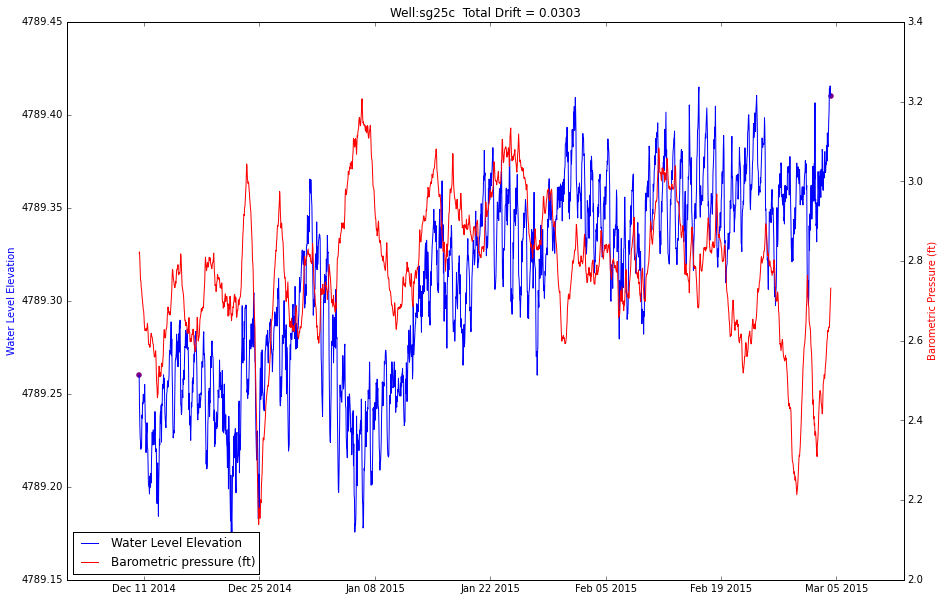

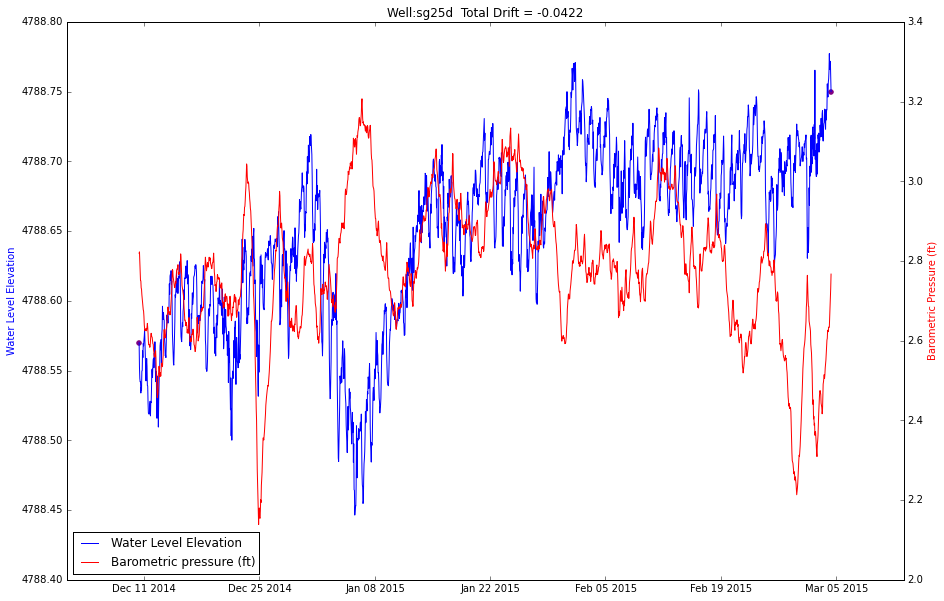

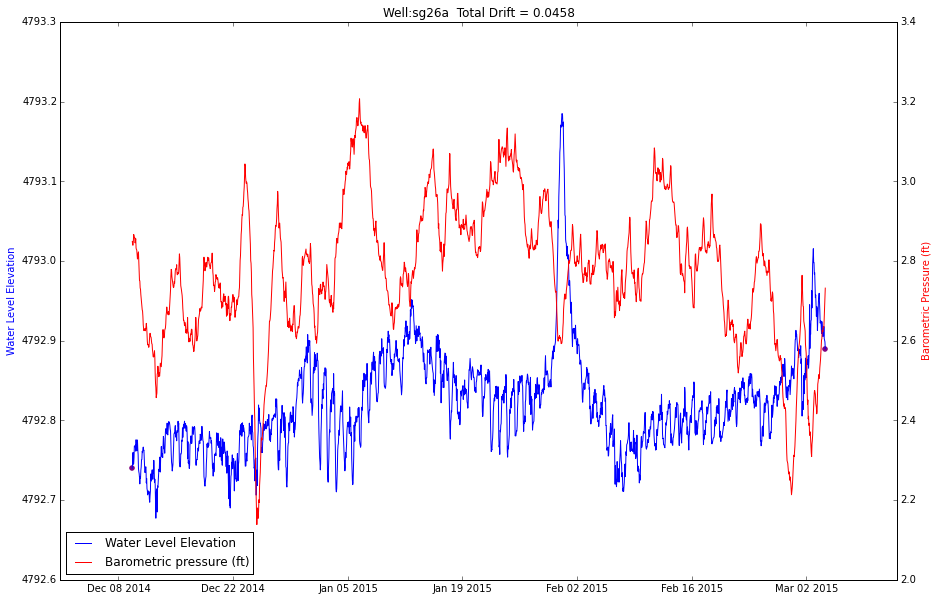

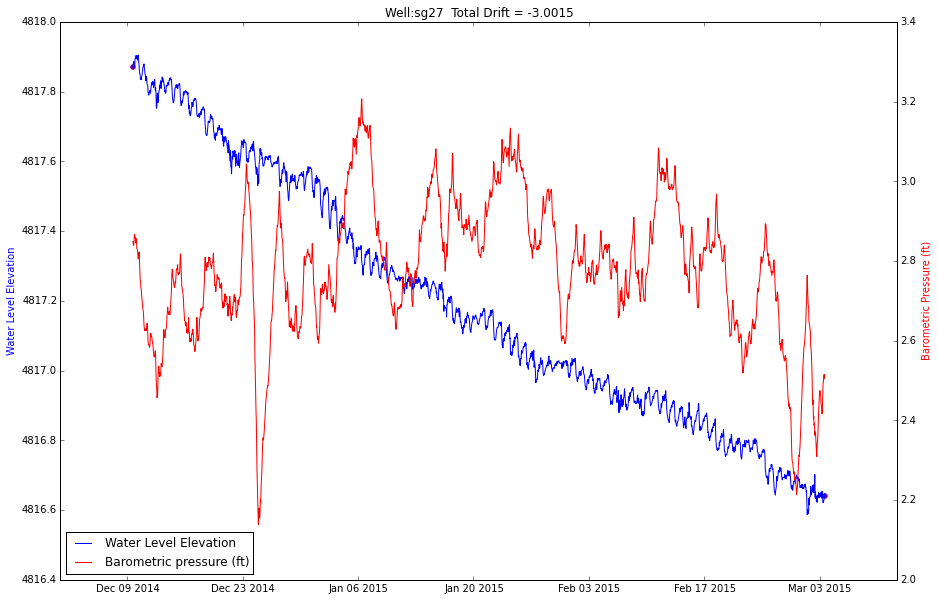

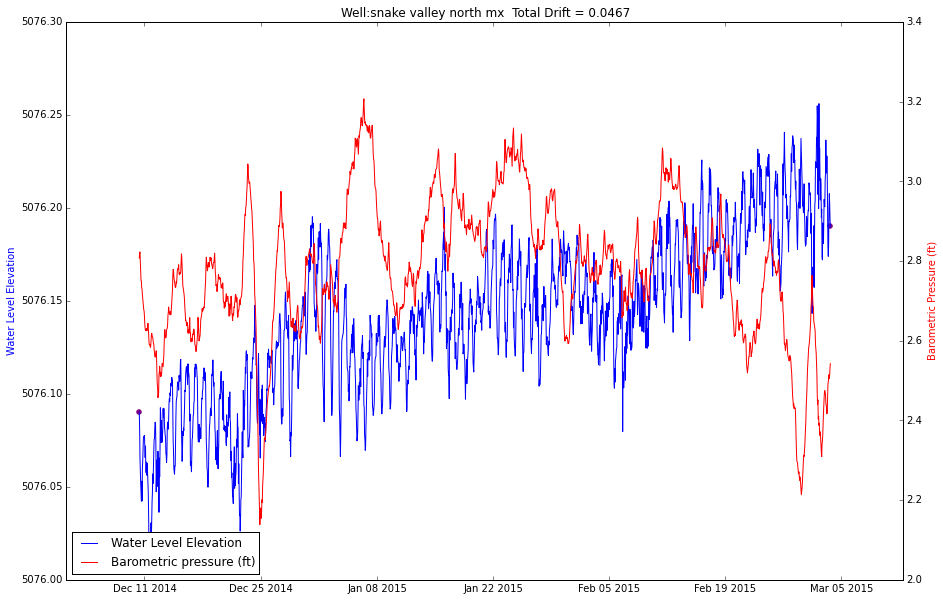

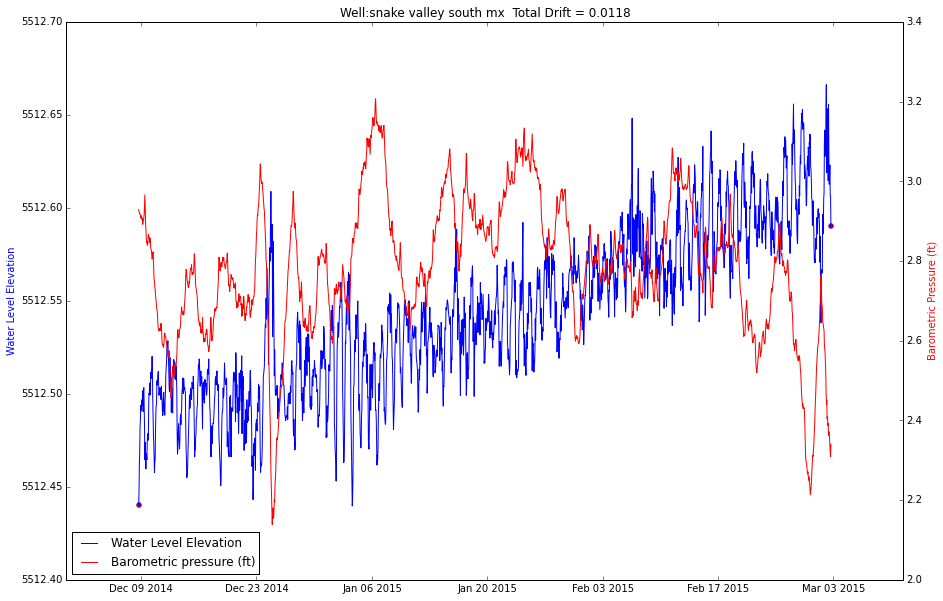

In [27]:
pdf_pages = PdfPages(folder+'wells.pdf')
for i in wellinfo.loc[:,'full_file_name']:
    g = imp_new_well(folder+'\\'+i, wellinfo, manual, baro)
    glist = g.columns.tolist()
    for j in range(len(glist)):
        if 'pw' in glist[j]:
            h = glist[j]
    y1 = g['WaterElevation'].values
    y2 = g[h].values
    x1 = g['DateTime'].values
    wellname, wellid = getwellid(folder+'\\'+i,wellinfo)
    ylast = wellinfo[wellinfo['WellID']==wellid]['GroundElevation'].values[0] + wellinfo[wellinfo['WellID']==wellid]['Offset'].values[0] - fcl(manual[manual['WellID']== wellid],max(g.index.to_datetime()))[1]
    yfirst = wellinfo[wellinfo['WellID']==wellid]['GroundElevation'].values[0] + wellinfo[wellinfo['WellID']==wellid]['Offset'].values[0] - fcl(manual[manual['WellID']== wellid],min(g.index.to_datetime()))[1]
    xlast = (fcl(manual[manual['WellID']== wellid],max(g.index.to_datetime()))).name.to_datetime()
    xfirst = (fcl(manual[manual['WellID']== wellid],min(g.index.to_datetime()))).name.to_datetime()
    x4 = [xfirst,xlast]
    y4 = [yfirst,ylast]
    fig, ax1 = plt.subplots()
    ax1.scatter(x4,y4,color='purple')
    ax1.plot(x1,y1,color='blue',label='Water Level Elevation')
    ax1.set_ylabel('Water Level Elevation',color='blue')
    y_formatter = tick.ScalarFormatter(useOffset=False)
    ax1.yaxis.set_major_formatter(y_formatter)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Barometric Pressure (ft)', color='red') 
    ax2.plot(x1,y2,color='red',label='Barometric pressure (ft)')
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc=3)
    
    plt.title('Well: ' + wellname.title() + '  ' + 'Total Drift = ' + str(g['DriftCorrection'][-1]))
    pdf_pages.savefig(fig)
    fig.close()
pdf_pages.close()

#### Import One File

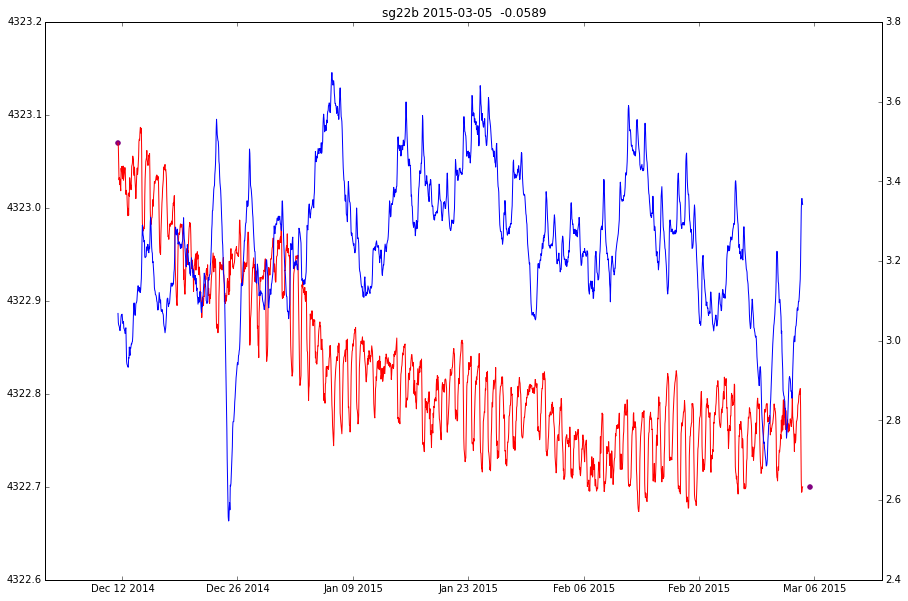

In [39]:
inputfile = "E:\\Snake Valley Water\\Transducer Data\\Raw_data_archive\\2015\\2015 q1\\sg22b 2015-03-05.xle"

g = imp_new_well(inputfile, wellinfo, manual)
glist = g.columns.tolist()
for j in range(len(glist)):
        if 'pw' in glist[j]:
            h = glist[j]
y1 = g['WaterElevation'].values
y2 = g[h].values
x1 = g['DateTime'].values

wellname, wellid = getwellid(inputfile)
ylast = wellinfo[wellinfo['WellID']==wellid]['GroundElevation'].values[0] + wellinfo[wellinfo['WellID']==wellid]['Offset'].values[0] - fcl(manual[manual['WellID']== wellid],max(g.index.to_datetime()))[1]
yfirst = wellinfo[wellinfo['WellID']==wellid]['GroundElevation'].values[0] + wellinfo[wellinfo['WellID']==wellid]['Offset'].values[0] - fcl(manual[manual['WellID']== wellid],min(g.index.to_datetime()))[1]
xlast = (fcl(manual[manual['WellID']== wellid],max(g.index.to_datetime()))).name.to_datetime()
xfirst = (fcl(manual[manual['WellID']== wellid],min(g.index.to_datetime()))).name.to_datetime()
x4 = [xfirst,xlast]
y4 = [yfirst,ylast]

fig, ax1 = plt.subplots()
ax1.scatter(x4,y4,color='purple')
ax1.plot(x1,y1,color='red')
y_formatter = tick.ScalarFormatter(useOffset=False)
ax1.yaxis.set_major_formatter(y_formatter)
ax2 = ax1.twinx()
ax2.plot(x1,y2,color='blue')
plt.title(getfilename(inputfile)+'  '+str(g['DriftCorrection'][-1]))
plt.show()

### Combine Output

In [41]:
q = {}

for i in wellinfo.loc[:,'full_file_name']:
    wellname, wellid = getwellid(folder+'\\'+i)
    q[wellname] = imp_new_well(folder+'\\'+i, wellinfo, manual)


TypeError: unbound method append() must be called with DataFrame instance as first argument (got dict instance instead)

In [45]:
q.names.to_list()

AttributeError: 'dict' object has no attribute 'names'

In [ ]:
alldf = ag13a.append(q)
outpath = pathlist[0] + '\\' + pathlist[1] + '\\' + pathlist[2] + '\\' + pathlist[3] + '\\' + pathlist[4] + '\\' + 'all' + '.csv'
alldf.to_csv(outpath, index=False, columns= ["WellID","DateTime","MeasuredLevel","Temp","BaroEfficiencyCorrected","DeltaLevel",
                                             "MeasuredDTW","DriftCorrection","DTWBelowCasing","DTWBelowGroundSurface",
                                             "WaterElevation","Tape","MeasuredBy"])

In [71]:
dailyavgfiles = r"U:\GWP\Snake Valley Water\Transducer Data\Individual Sites\Daily Averages"

In [72]:
well = r"U:\GWP\Snake Valley Water\Transducer Data\Individual Sites\Daily Averages\ag13b.xlsx"

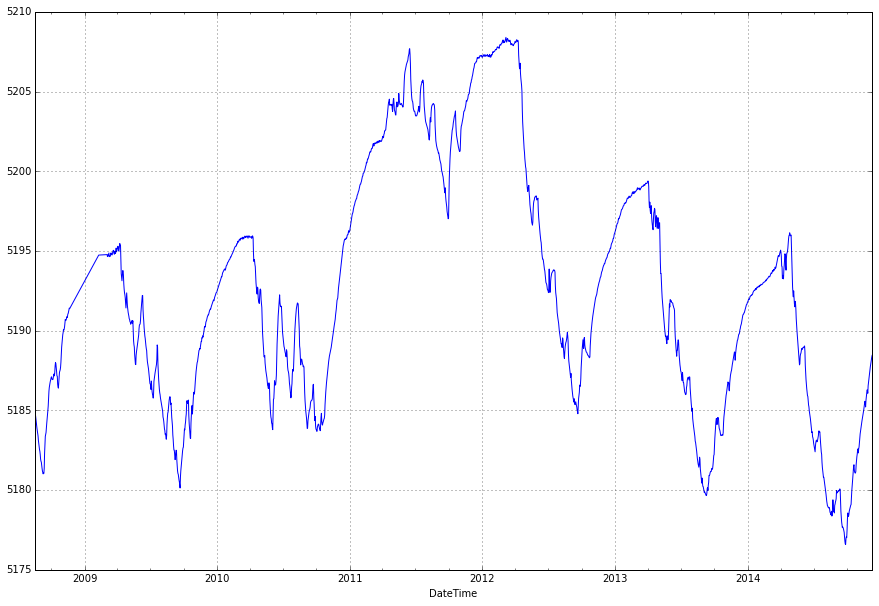

In [90]:
hourly = pd.read_excel(well,'input',parse_dates=True,index_col='DateTime')
hwl = hourly["WaterElevation"].resample('D',how='mean')
hwl = hwl.interpolate(how='Time')
hwl.plot()

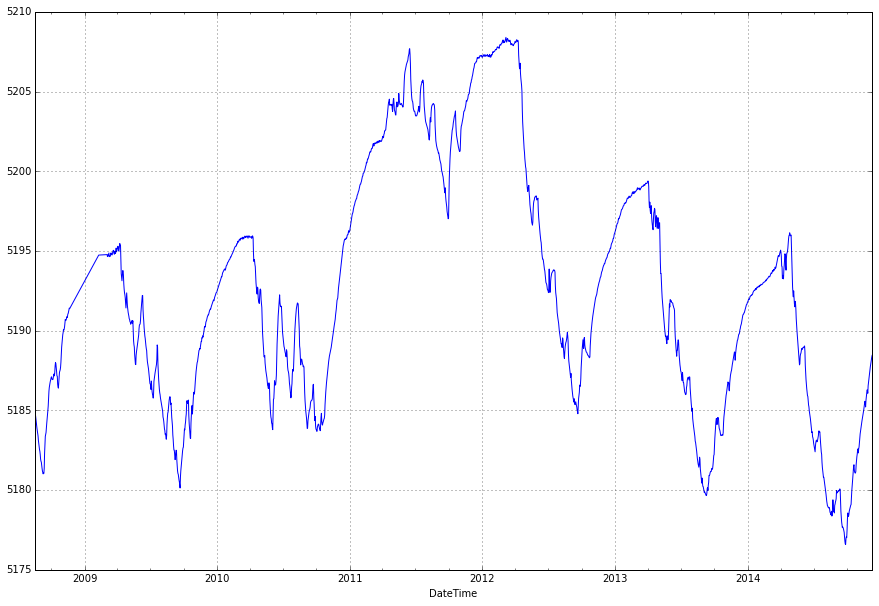